# Import libraries and set configs

In [1]:
import sys
sys.path.append('..')

import os
import json
import joblib
import random
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from glob import glob
from optimizer.optimizer import Optimizer
from os import environ
from datetime import timedelta
from tqdm.auto import tqdm
from datetime import datetime

from eli5.sklearn import PermutationImportance

import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, precision_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')

from colorama import Style, Fore

# Set environment variable
environ["ENV"] = "optimize"

from config.config import ConfigFactory
from indicators import indicators

from api.tvdatafeed.main import TvDatafeed, Interval
from constants.constants import tv_username, tv_password


class CFG:
    load = False
    historical = False
    create_dataset = True
    cls_target_ratio_tp = 1.03
    cls_target_ratio_sl = 1.03
    ttype = 'both'
    patterns_to_filter = ['STOCH_RSI_Volume24']
    select_features = False
    optimize = False
    n_repeats = 1
    n_folds = 8
    agg_periods = [24, 168, 720]
    agg_funcs = [np.min, np.max, np.mean, np.median, np.std]

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

tqdm.pandas()

warnings.simplefilter(action='ignore', category=(FutureWarning, pd.errors.PerformanceWarning))

# Load data

### Load STOCH_RSI buy data

In [2]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'buy'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=True, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=True, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat) # 31060

### Load STOCH_RSI sell data

In [3]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'sell'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat) # 23629

# Test loaded data

### Remove dataframe files with the biggest number of missing data

In [4]:
counter = 0 

tickers_1h = glob('../optimizer/ticker_dataframes/*_1h.pkl')
for ticker in tqdm(tickers_1h[3:]):
    df = pd.read_pickle(ticker)
    nunique = df['time'].diff()[1:].nunique()
    if nunique > 1:
        count = df[df['time'].diff().astype('timedelta64[h]') != 1].shape[0]
        if count > 200:
            print(ticker, nunique, count)
            os.remove(ticker)
            os.remove(ticker[:-6] + '4h.pkl')
            
counter

  0%|          | 0/2314 [00:00<?, ?it/s]

0

### Plot time vs index for some of dataframe files

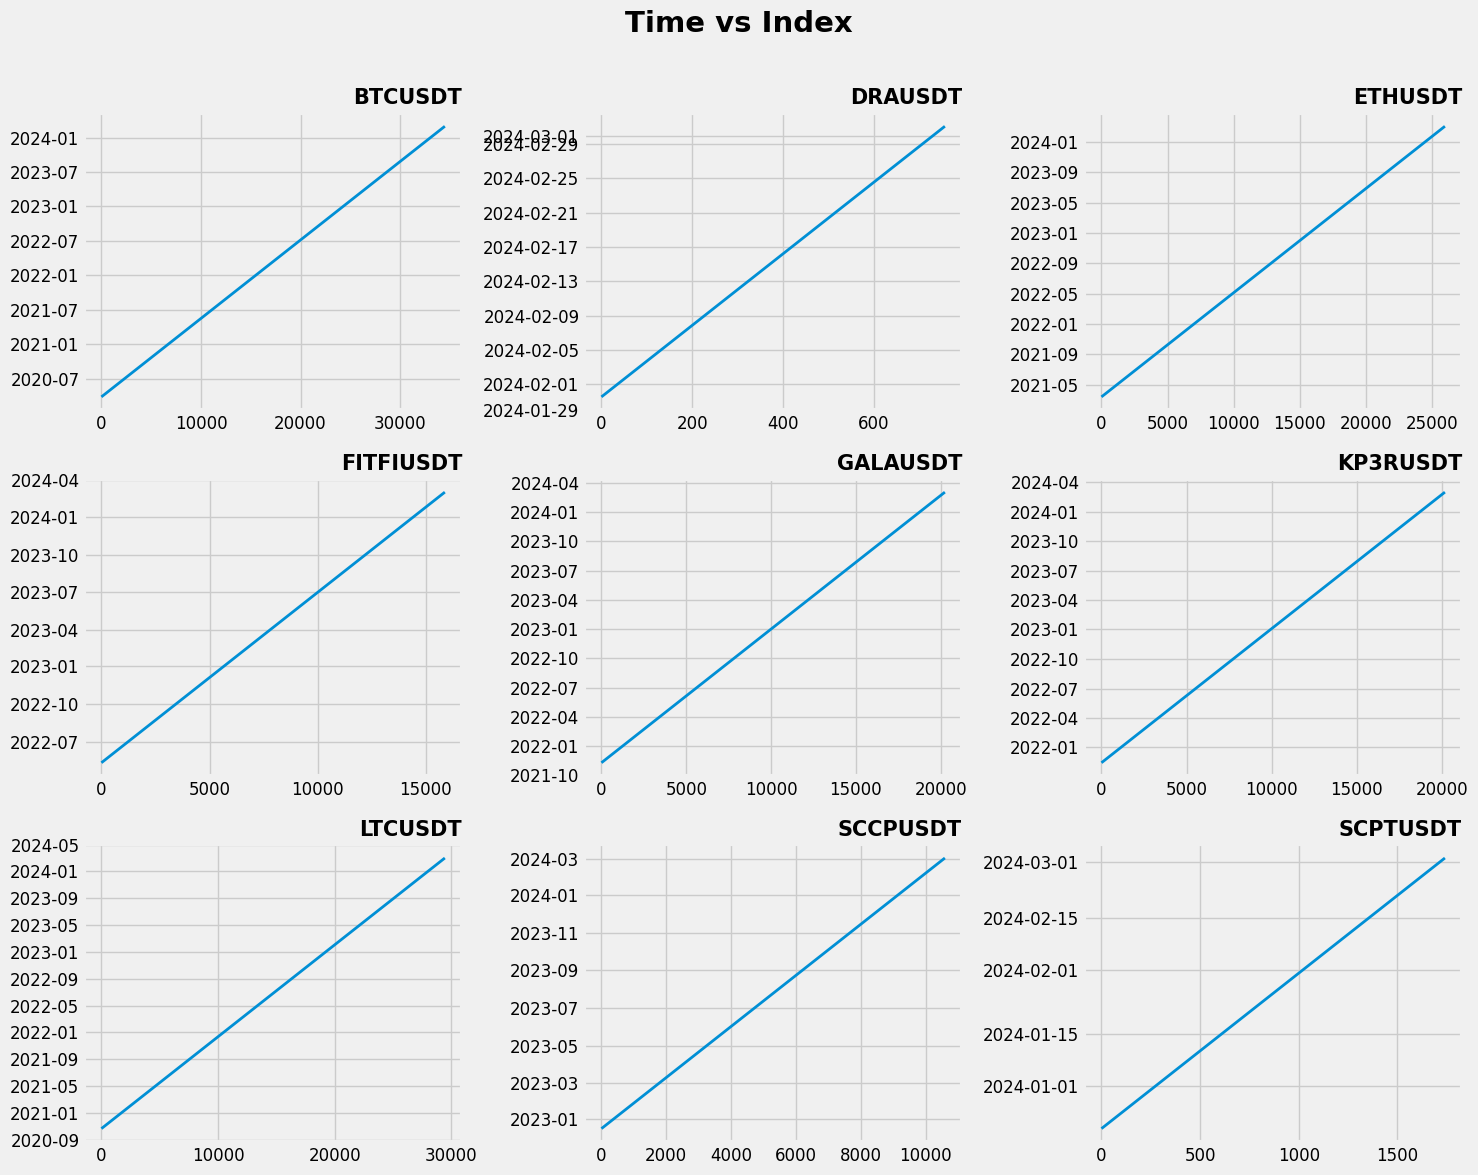

In [5]:
%matplotlib inline

n_cols = 3
n_rows = 3
figsize = (15, 4 * n_rows)

tickers = glob('../optimizer/ticker_dataframes/*_1h.pkl')
random_tickers = random.choices(tickers, k=n_cols*n_rows)
random_tickers[:3] = [t for t in tickers if '/BTCUSDT_1h' in t or '/ETHUSDT_1h' in t or '/LTCUSDT_1h' in t]

def plot_times(random_tickers, n_rows, n_cols):
    fig = plt.figure(figsize=figsize)
    
    for idx in range(n_cols*n_rows):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        
        df = pd.read_pickle(random_tickers[idx])
        sns.lineplot(data=df['time'])

        ax.set_ylabel('')
        plt.yticks(fontsize=12) 
        ax.set_xlabel('')
        plt.xticks(fontsize=12)
        # ax.spines['right'].set_visible(False)
        ax.set_title(f'{random_tickers[idx].split("/")[-1][:-7]}', loc='right', weight='bold', fontsize=15)
        ax.lines[0].set_linewidth(2)

    
    fig.suptitle(f'Time vs Index\n', ha='center',  fontweight='bold', fontsize=21)
    # fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
plot_times(sorted(random_tickers),  n_rows=n_rows, n_cols=n_cols) 

### Check if all dataframe files has data for both timeframes 1h and 4h

In [6]:
import glob

x = glob.glob('../optimizer/ticker_dataframes/*.pkl')
y = [i[31:].split('_')[0] for i in x]
z = ('').join(x)

for i in y:
    if f'{i}_1h' not in z:
        print(i, '1h')
    if f'{i}_4h' not in z:
        print(i, '4h')

# Prepare and create train data

### Functions

In [7]:
# Get configs
configs = ConfigFactory.factory(environ).configs

higher_features = ['time', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist', 'macdsignal']
price_cols = ['open','high', 'low', 'close']
real_price_cols = ['real_high', 'real_low', 'real_close']
funding_cols = ['funding_rate']
rsi_stoch_cols = ['rsi', 'stoch_diff', 'stoch_slowd', 'stoch_slowk']
btcd_cols = ['time', 'btcd_open', 'btcd_high', 'btcd_low', 'btcd_close', 'btcd_volume']
btcdom_cols = ['time', 'btcdom_open', 'btcdom_high', 'btcdom_low', 'btcdom_close', 'btcdom_volume']

def get_file(ticker):
    ''' Find files buy ticker names '''
    try:
        tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
        tmp_df_4h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')
    except FileNotFoundError:
        return None, None
    else:
        return tmp_df_1h, tmp_df_4h

def add_indicators(df, df_higher, ttype, configs):
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, '', '', 0)
    # add Stochastic
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, '', '', 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, '', '', 0)
    # add MACD
    macd = indicators.MACD(ttype, configs)
    df_higher = macd.get_indicator(df_higher, '', '', 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    df_higher = trend.get_indicator(df_higher, '', '', 0)
    # merge higher timeframe indicators with working timeframe
    df_higher['time'] = df_higher['time'] + pd.to_timedelta(3, unit='h')
    df[higher_features] = pd.merge(df[['time']], df_higher[higher_features], how='left', on='time')
    df.drop(columns=['close_smooth'], inplace=True)
    df.drop(columns=[c for c in df.columns if c.endswith('_dir')], inplace=True)
    # merge with BTC.D dataframe
    df[btcd_cols] = pd.merge(df[['time']], btcd[btcd_cols], how='left', on='time')
    # merge with BTCDOM dataframe
    df[btcdom_cols] = pd.merge(df[['time']], btcdom[btcdom_cols], how='left', on='time')
    df.ffill(inplace=True)
    df[btcdom_cols] = df[btcdom_cols].fillna(df[btcdom_cols].mean().round(1))
    # price and MACD columns to pct difference
    df[real_price_cols] = df[['high', 'low', 'close']]
    cols_to_scale = ['open', 'high', 'low', 'close', 'macd', 'macdhist', 'macdsignal', 'atr']
    for c in cols_to_scale:
        df[c] = df[c].pct_change() * 100
    return df.reset_index(drop=True)

# DHPUSDT 2022-02-01 23:00:00
def create_train_df(df, ttype, configs, target_offset, first, last, step):
    ''' Create train dataset from signal statistics and ticker candle data'''
    train_df = pd.DataFrame()
    # tickers = ['ZILUSDT'] # !!!
    tickers = df['ticker'].unique()
    
    for ticker in tqdm(tickers):
        # get signals with current ticker
        signal_df = df[df['ticker'] == ticker]
        times = signal_df['time']
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        try:
            tmp_df_1h = add_indicators(tmp_df_1h, tmp_df_4h, ttype, configs)
        except TypeError:
            # print(f'TypeError, ticker - {ticker}')
            continue

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            pass_cycle, sl = False, False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc('pattern')]
            row = tmp_df_1h.loc[tmp_df_1h['time'] == t, :].reset_index(drop=True)
            
            # if t.year == 2024 and t.month == 2 and t.day == 15 and t.hour == 22: # !!!
            #     pass
            
            for i in range(first, last + 1, step):
                # collect features every 4 hours, save difference between the current feature and the lagged features
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h['time'] == time_prev, [c for c in tmp_df_1h.columns if c not in real_price_cols]].reset_index(drop=True)
                    if i % 8 != 0:
                        row_tmp = row_tmp.drop(columns=funding_cols)
                    if i % 24 != 0:
                        row_tmp = row_tmp.drop(columns=btcd_cols)
                    row_tmp.columns = [c + f'_prev_{i}' for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
                row['ticker'] = ticker
                row['pattern'] = pattern
                
            if pass_cycle:
                continue

            row['target'] = 0
            row['ttype'] = ttype
            
            # If ttype = buy and during the selected period high price was higher than close_price * target_ratio
            # and earlier low price wasn't lower than close_price / target_ratio, than target is True, else target is False.
            # Similarly for ttype = sell 
            if pattern.startswith('MACD'):
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t + timedelta(hours=3), 'real_close']
            else:
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t, 'real_close']

            # move to the next ticker if can't find any data corresponding to time t
            if close_price.shape[0] == 0:
                break
            
            close_price = close_price.values[0]
            
            for i in range(1, target_offset + 1):
                if pattern.startswith('MACD'):
                    time_next = t + timedelta(hours=3+i)
                else:
                    time_next = t + timedelta(hours=i)
                    
                target_buy = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_high']
                target_sell = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_low']
                
                if target_buy.shape[0] == 0 or target_sell.shape[0] == 0:
                    pass_cycle = True
                    break
                
                target_buy = target_buy.values[0]
                target_sell = target_sell.values[0]

                # set 
                higher_price = close_price * CFG.cls_target_ratio_tp
                lower_price = close_price * (2 - CFG.cls_target_ratio_tp)
                target_buy_tp = 1 if target_buy > higher_price else 0
                target_buy_sl = 1 if target_buy > higher_price else 0
                target_sell_tp = 1 if target_sell < lower_price else 0
                target_sell_sl = 1 if target_sell < lower_price else 0

                pattern = row['pattern'].values[0]
                ttype = row['ttype'].values[0]
                
                # set SL flag and exit cycle if price reaches stop-loss threshold before it reaches take-profit threshold
                # (SL depends on ttype and pattern)
                sl1 = pattern.startswith('STOCH') and ttype == 'buy' and target_buy_sl == 1
                sl2 = pattern.startswith('STOCH') and ttype == 'sell' and target_sell_sl == 1

                # set TP flag and exit cycle if price reaches take-profit threshold and doesn't reach stop-loss threshold before
                # (TP depends on ttype and pattern)
                tp1 = pattern.startswith('STOCH') and ttype == 'buy' and target_sell_tp == 1
                tp2 = pattern.startswith('STOCH') and ttype == 'sell' and target_buy_tp == 1
                    
                # if both TP and SL flag is on - don't consider that trade
                if (tp1 and sl1) or (tp2 and sl2):
                    pass_cycle = True
                    break
                elif sl1 or sl2:
                    break
                elif tp1 or tp2:
                    row['target'] = 1
                    break
                
                # if price doesn't reaches both TP and SL thresholds but price above / below enter price for buy / sell trade - set TP flag
                # (depends on ttype and pattern)
                if i == target_offset: 
                    last_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_close'].values[0]
                    l1 = pattern.startswith('STOCH') and ttype == 'buy' and last_price < close_price
                    l2 = pattern.startswith('STOCH') and ttype == 'sell' and last_price > close_price

                    if l1 or l2:
                        row['target'] = 1
            
            if pass_cycle:
                continue

            # add aggregates
            # for col in ['open', 'close', 'low', 'high', 'volume']:
            #     for period in CFG.agg_periods:
            #         for agg_func in CFG.agg_funcs:
            #             tmp_len = min(len(tmp_df_1h), period)
            #             stat_val = tmp_df_1h.iloc[-tmp_len:, tmp_df_1h.columns.get_loc(col)].rolling(period, min_periods=1).agg({'func': agg_func}).values[-1, 0]
            #             row[f'{col}_{agg_func.__name__}_{period}'] = stat_val
            
            # add data to the dataset
            if train_df.shape[0] == 0:
                train_df = row
            else:
                train_df = pd.concat([train_df, row])
    
    train_df = train_df.drop(columns=real_price_cols)
    return train_df


### Prepare train data

In [8]:
# last previous data point to collect for model training (value represents number of hours before signal point)
last = 512

if CFG.create_dataset:
    # Get BTC dominance
    tv = TvDatafeed(username=tv_username, password=tv_password)
    
    btcd = tv.get_hist('BTC.D','CRYPTOCAP', interval=Interval.in_daily, n_bars=7000, extended_session=True).reset_index()
    btcd = btcd.drop(columns='symbol')
    btcd.columns = btcd_cols
    btcd['time'] = btcd['time'] + pd.to_timedelta(23, unit='h')

    btcdom = tv.get_hist('BTCDOMUSDT.P','BINANCE', interval=Interval.in_4_hour, n_bars=7000, extended_session=True).reset_index()
    btcdom = btcdom.drop(columns='symbol')
    btcdom.columns = btcdom_cols
    btcdom['time'] = btcdom['time'] + pd.to_timedelta(3, unit='h')
    
    # for how long time (in hours) we want to predict
    target_offset = 96
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 4
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # good hours: 
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    # buy_hours_to_save = [0, 1, 2, 3, 16, 17, 21, 22, 23]
    # df = df[df['time'].dt.hour.isin(buy_hours_to_save)]
    # dataset for model train
    train_buy = create_train_df(df, 'buy', configs, target_offset, first, last, step)
    train_buy = train_buy.dropna()
    train_buy.to_pickle(f'signal_stat/train_buy_{last}.pkl')

    display(train_buy.head())
    display(train_buy.shape)

    # Sell
    # good hours 
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    # sell_hours_to_save = [1, 4, 14, 16, 17, 18, 19, 21, 23]
    # df = df[df['time'].dt.hour.isin(sell_hours_to_save)]
    # dataset for model train
    train_sell = create_train_df(df, 'sell', configs, target_offset, first, last, step)
    train_sell = train_sell.dropna()
    train_sell.to_pickle(f'signal_stat/train_sell_{last}.pkl')

    # this is made for tests
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]

    test_df_buy_1 = df[df['time'].dt.hour.isin(buy_hours_to_save[0:1])]
    test_df_buy_1 = create_train_df(test_df_buy_1, 'buy', configs, target_offset, first, last, step)
    test_df_buy_1 = test_df_buy_1.dropna().sort_values('time').reset_index(drop=True)

    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    
    test_df_sell_1 = df[df['time'].dt.hour.isin(sell_hours_to_save[0:1])]
    test_df_sell_1 = create_train_df(test_df_sell_1, 'sell', configs, target_offset, first, last, step)
    test_df_sell_1 = test_df_sell_1.dropna().sort_values('time').reset_index(drop=True)

    del df

    display(train_sell.head())
    display(train_sell.shape)

error while signin
you are using nologin method, data you access may be limited


  0%|          | 0/1368 [00:00<?, ?it/s]

### Create train dataset

In [ ]:
train_buy = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
train_sell = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')

train_df = pd.concat([train_buy, train_sell])
train_df = train_df.sort_values('time')

# do not consider the last signals - they may contain erroneus signals
train_df = train_df[train_df['time'] < train_df['time'].max()].reset_index(drop=True)


# Data tests

### Test train dataframe columns

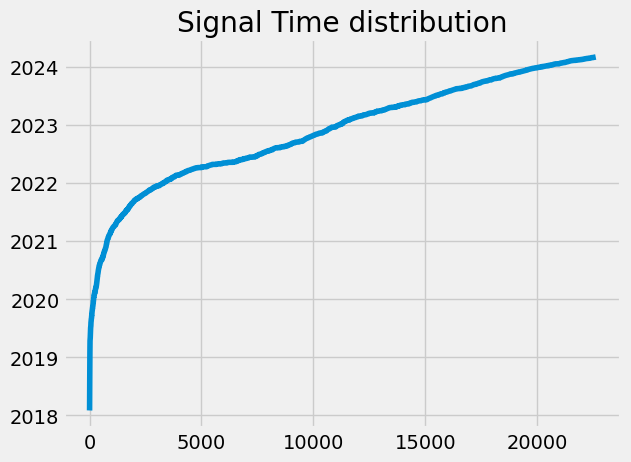

In [ ]:
import re

if CFG.create_dataset:

    # check if train dataset has only columns that we expect
    cols = set(re.sub(r'_prev_\d+', '', c) for c in train_buy.columns)
    expected_cols = set(price_cols + higher_features + funding_cols + rsi_stoch_cols +
                        btcd_cols + btcdom_cols + ['atr', 'pattern', 'target', 'ticker', 'ttype', 'volume'])
    assert expected_cols == cols

    # check RSI and STOCH columns, their values must be in [0, 100] range 
    rsi_stoch_cols_ = [c for c in train_df.columns if ('rsi' in c or 'stoch' in c) and 'diff' not in c]
    for r_s_c in rsi_stoch_cols_:
        assert train_df[r_s_c].min() > -0.0001
        assert train_df[r_s_c].max() < 100.0001

    # check volume columns, their values must be >= 0
    vol_cols_ = [c for c in train_df.columns if 'volume' in c]
    for v_c in vol_cols_:
        assert train_df[v_c].min() >= 0

    # check funding columns, their period must be 8 hours
    funding_cols_ = [c for c in train_df.columns if c.startswith('funding')]
    for f_c in funding_cols_:
        num = ''.join([i for i in f_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 8 == 0

    # check BTC dominance columns, their values must be in [0, 100] range 
    # and their period must be 24 hours
    btcd_cols_ = [c for c in train_df.columns if c.startswith('btcd_') and 'volume' not in c]
    for b_c in btcd_cols_:
        # check values
        assert train_df[b_c].min() >= 0
        assert train_df[b_c].max() <= 100
        # check period
        num = ''.join([i for i in b_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 24 == 0

    # check the rest columns, their period must be 4 hours
    rest_cols_ = [c for c in train_df.columns if c not in funding_cols_ and c not in btcd_cols]
    for r_c in rest_cols_:
        num = ''.join([i for i in r_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 4 == 0

    # check if changing of source dataframe doesn't affect the resulting train dataframe
    test_df_buy_2 = train_buy[train_buy['time'].dt.hour.isin(buy_hours_to_save[0:1])]
    assert test_df_buy_1.shape == test_df_buy_2.shape
    test_df_sell_2 = train_sell[train_sell['time'].dt.hour.isin(sell_hours_to_save[0:1])]
    assert test_df_sell_1.shape == test_df_sell_2.shape

    # plot time values 
    train_df['time'].plot(title='Signal Time distribution')


### Test buy target corectness

In [ ]:
# if CFG.create_dataset:
prev_ticker = None
target_offset = 96

if CFG.create_dataset:
    for i in tqdm(range(train_buy.shape[0])):
        x = train_buy[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
        y = x.iloc[i]
        pattern, ticker, time_, target = y['pattern'], y['ticker'], y['time'], y['target']

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h['time'] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0]
        last_idx = min(idx+target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc('close')]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h['low_price'] = low_price
        tmp_df_1h['high_price'] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]
        tmp_df_1h['signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']
        tmp_df_1h['anti_signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
        
        first_signal = tmp_df_1h['signal'].argmax()
        first_anti_signal = tmp_df_1h['anti_signal'].argmax()
        
        if tmp_df_1h['signal'].max() == 0 and tmp_df_1h['anti_signal'].max() == 0:
            if pattern.startswith('STOCH'): 
                if last_price < close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h['signal'].max() == 0:
            assert target == 0
        elif tmp_df_1h['anti_signal'].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal > first_anti_signal

  0%|          | 0/13364 [00:00<?, ?it/s]

### Test sell target corectness

In [ ]:
if CFG.create_dataset:
    for i in tqdm(range(train_sell.shape[0])):
        x = train_sell[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
        y = x.iloc[i]
        pattern, ticker, time_, target = y['pattern'], y['ticker'], y['time'], y['target']

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h['time'] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0]
        last_idx = min(idx+target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc('close')]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h['low_price'] = low_price
        tmp_df_1h['high_price'] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]
        tmp_df_1h['signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
        tmp_df_1h['anti_signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']

        first_signal = tmp_df_1h['signal'].argmax()
        first_anti_signal = tmp_df_1h['anti_signal'].argmax()
        
        if tmp_df_1h['signal'].max() == 0 and tmp_df_1h['anti_signal'].max() == 0:
            if pattern.startswith('STOCH'):
                if last_price > close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h['signal'].max() == 0:
            assert target == 0
        elif tmp_df_1h['anti_signal'].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal > first_anti_signal

  0%|          | 0/9253 [00:00<?, ?it/s]

### Test pattern / target distribution

In [ ]:
def trust_interval(row, z=1.95):
    """ Calculate trust interval for Bernulli distribution """
    sum, val1 = row['total'], row['count']
    val2 = sum - val1
    n = val1 + val2
    p = val1 / n
    low_bound = p - z * np.sqrt(p * (1-p) / n)
    high_bound = p + z * np.sqrt(p * (1-p) / n)
    return round(low_bound, 4), round(high_bound, 4)

pvt = train_buy
pvt = pvt[['target', 'pattern', 'time']]
pvt['hour'] = pvt['time'].dt.hour
pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
pvt.rename(columns={'pattern': 'count'}, inplace=True)
pvt['pct'] = pvt['count'] / pvt['total']
pvt = pvt[pvt['target']==1]
pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)

print('Buy')
display(pvt)
display(train_buy['ttype'].value_counts())
display(train_buy[['target', 'pattern']].value_counts())
display(train_buy[['target', 'pattern']].value_counts(normalize=True))

pvt = train_sell
pvt = pvt[['target', 'pattern', 'time']]
pvt['hour'] = pvt['time'].dt.hour
pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
pvt.rename(columns={'pattern': 'count'}, inplace=True)
pvt['pct'] = pvt['count'] / pvt['total']
pvt = pvt[pvt['target']==1]
pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)

print('Sell')
display(pvt)
display(train_sell['ttype'].value_counts())
display(train_sell[['target', 'pattern']].value_counts())
display(train_sell[['target', 'pattern']].value_counts(normalize=True))

Buy


,hour,target,count,total,pct,trust_interval
1,0,1,700,1259,0.555997,"(0.5287, 0.5833)"
3,1,1,876,1622,0.540074,"(0.5159, 0.5642)"
5,2,1,820,1539,0.532814,"(0.508, 0.5576)"
7,3,1,945,1801,0.524708,"(0.5018, 0.5477)"
9,16,1,777,1428,0.544118,"(0.5184, 0.5698)"
11,17,1,760,1457,0.521620,"(0.4961, 0.5471)"
13,21,1,799,1479,0.540230,"(0.515, 0.5655)"
15,22,1,837,1500,0.558000,"(0.533, 0.583)"
17,23,1,733,1279,0.573104,"(0.5461, 0.6001)"


buy    13364
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    7247
0       STOCH_RSI_Volume24    6117
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.542278
0       STOCH_RSI_Volume24    0.457722
dtype: float64

Sell


,hour,target,count,total,pct,trust_interval
1,1,1,472,899,0.525028,"(0.4926, 0.5575)"
3,4,1,739,1388,0.532421,"(0.5063, 0.5585)"
5,14,1,722,1342,0.538003,"(0.5115, 0.5645)"
7,16,1,577,1089,0.529844,"(0.5004, 0.5593)"
9,17,1,521,925,0.563243,"(0.5314, 0.595)"
11,18,1,449,849,0.528857,"(0.4955, 0.5623)"
13,19,1,473,881,0.536890,"(0.5041, 0.5696)"
15,21,1,512,937,0.546425,"(0.5147, 0.5781)"
17,23,1,524,943,0.555673,"(0.5241, 0.5872)"


sell    9253
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    4989
0       STOCH_RSI_Volume24    4264
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.539176
0       STOCH_RSI_Volume24    0.460824
dtype: float64

# Data visualization

### Plot ratio of class 1 for every month

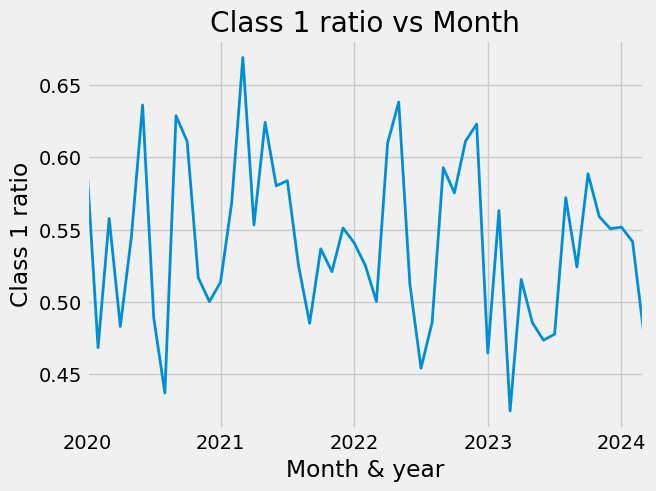

In [ ]:
train_df['date_month'] = train_df['time'].dt.to_period('M')
group_df = train_df[train_df['time'].dt.year >= 2020]
ax = group_df.groupby('date_month')['target'].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel('Month & year')
ax.set_ylabel('Class 1 ratio')
ax.set_title('Class 1 ratio vs Month')
train_df = train_df.drop(columns='date_month')

In [ ]:
#     hour	target	count	total	pct	trust_interval

# 1	0	1	700	1259	0.555997	(0.5287, 0.5833)
# 3	1	1	876	1622	0.540074	(0.5159, 0.5642)
# 5	2	1	820	1539	0.532814	(0.508, 0.5576)
# 7	3	1	945	1801	0.524708	(0.5018, 0.5477)
# 9	16	1	777	1428	0.544118	(0.5184, 0.5698)
# 11	17	1	760	1457	0.521620	(0.4961, 0.5471)
# 13	21	1	799	1479	0.540230	(0.515, 0.5655)
# 15	22	1	837	1500	0.558000	(0.533, 0.583)
# 17	23	1	733	1279	0.573104	(0.5461, 0.6001)

# 1	0	1	700	1259	0.555997	(0.5287, 0.5833)
# 3	1	1	876	1622	0.540074	(0.5159, 0.5642)
# 5	2	1	820	1539	0.532814	(0.508, 0.5576)
# 7	3	1	945	1801	0.524708	(0.5018, 0.5477)
# 9	16	1	777	1428	0.544118	(0.5184, 0.5698)
# 11	17	1	760	1457	0.521620	(0.4961, 0.5471)
# 13	21	1	799	1479	0.540230	(0.515, 0.5655)
# 15	22	1	837	1500	0.558000	(0.533, 0.583)
# 17	23	1	733	1279	0.573104	(0.5461, 0.6001)

### Visualize buy trades

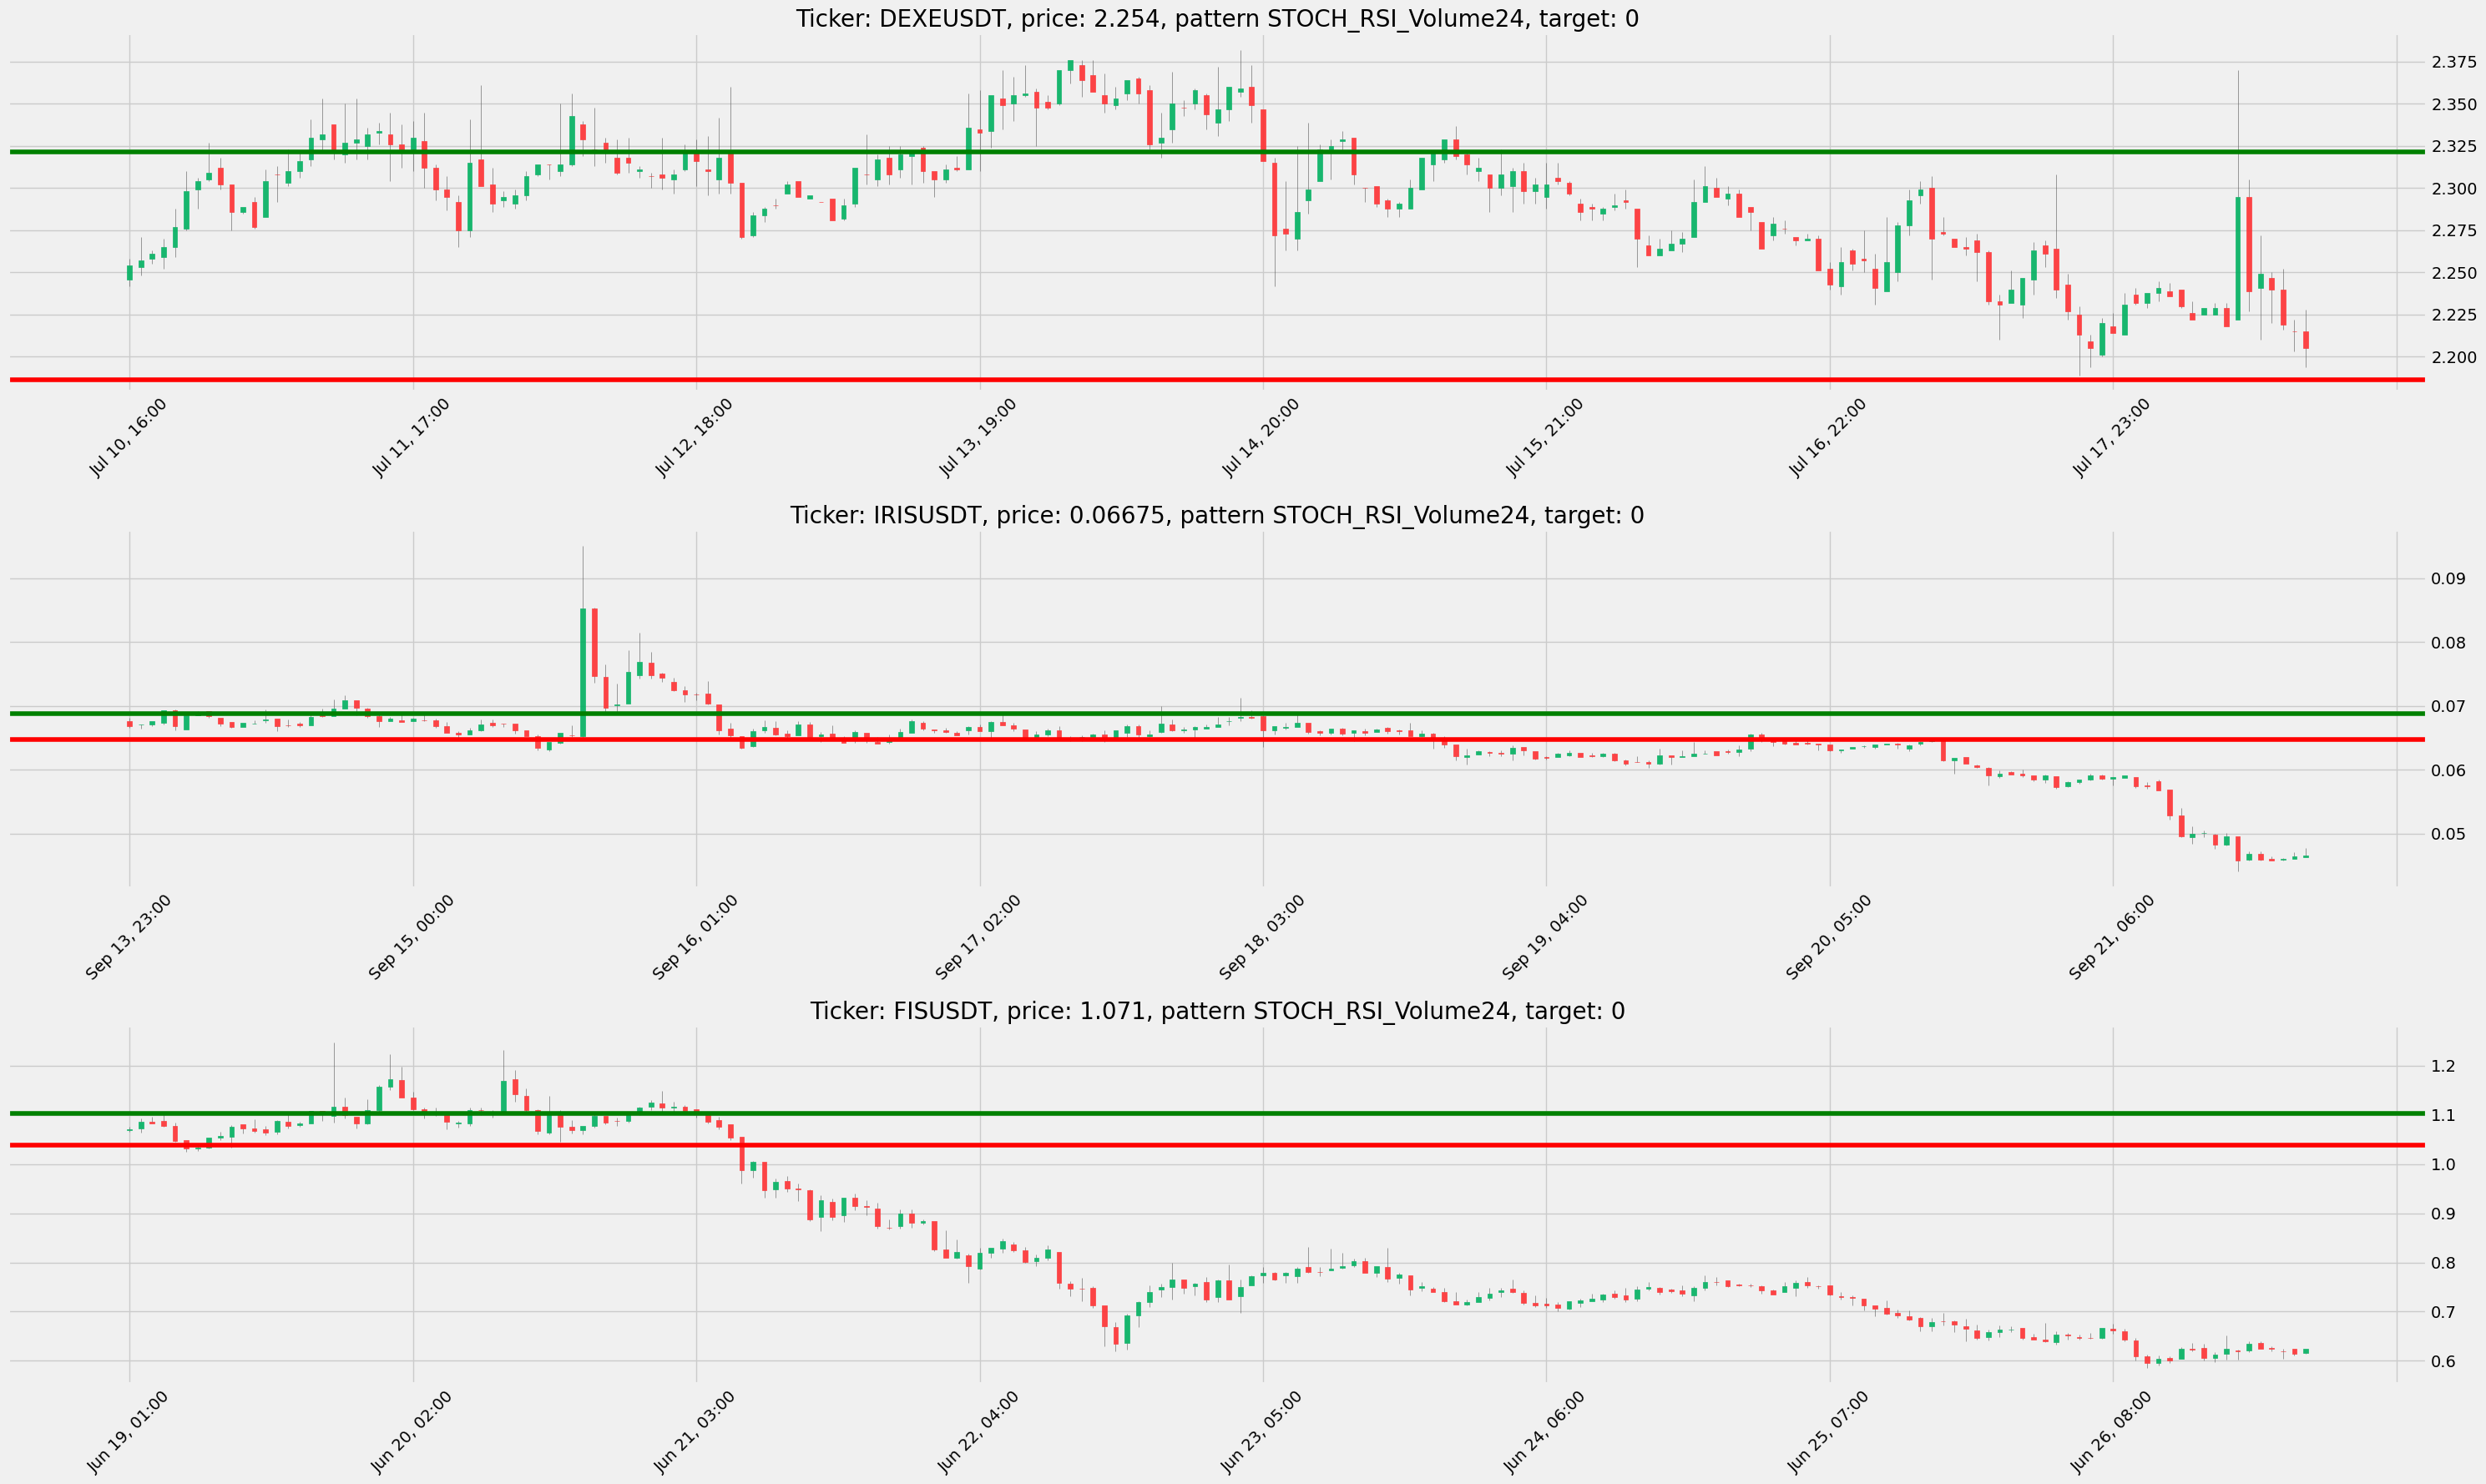

In [ ]:
import matplotlib.pyplot as plt
import mplfinance as mpf

if CFG.create_dataset:
    target_offset = 192
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_buy.index
    test_buy = train_buy.sample(plt_num, axis=0)

    for i, row in test_buy.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]

        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize sell trades

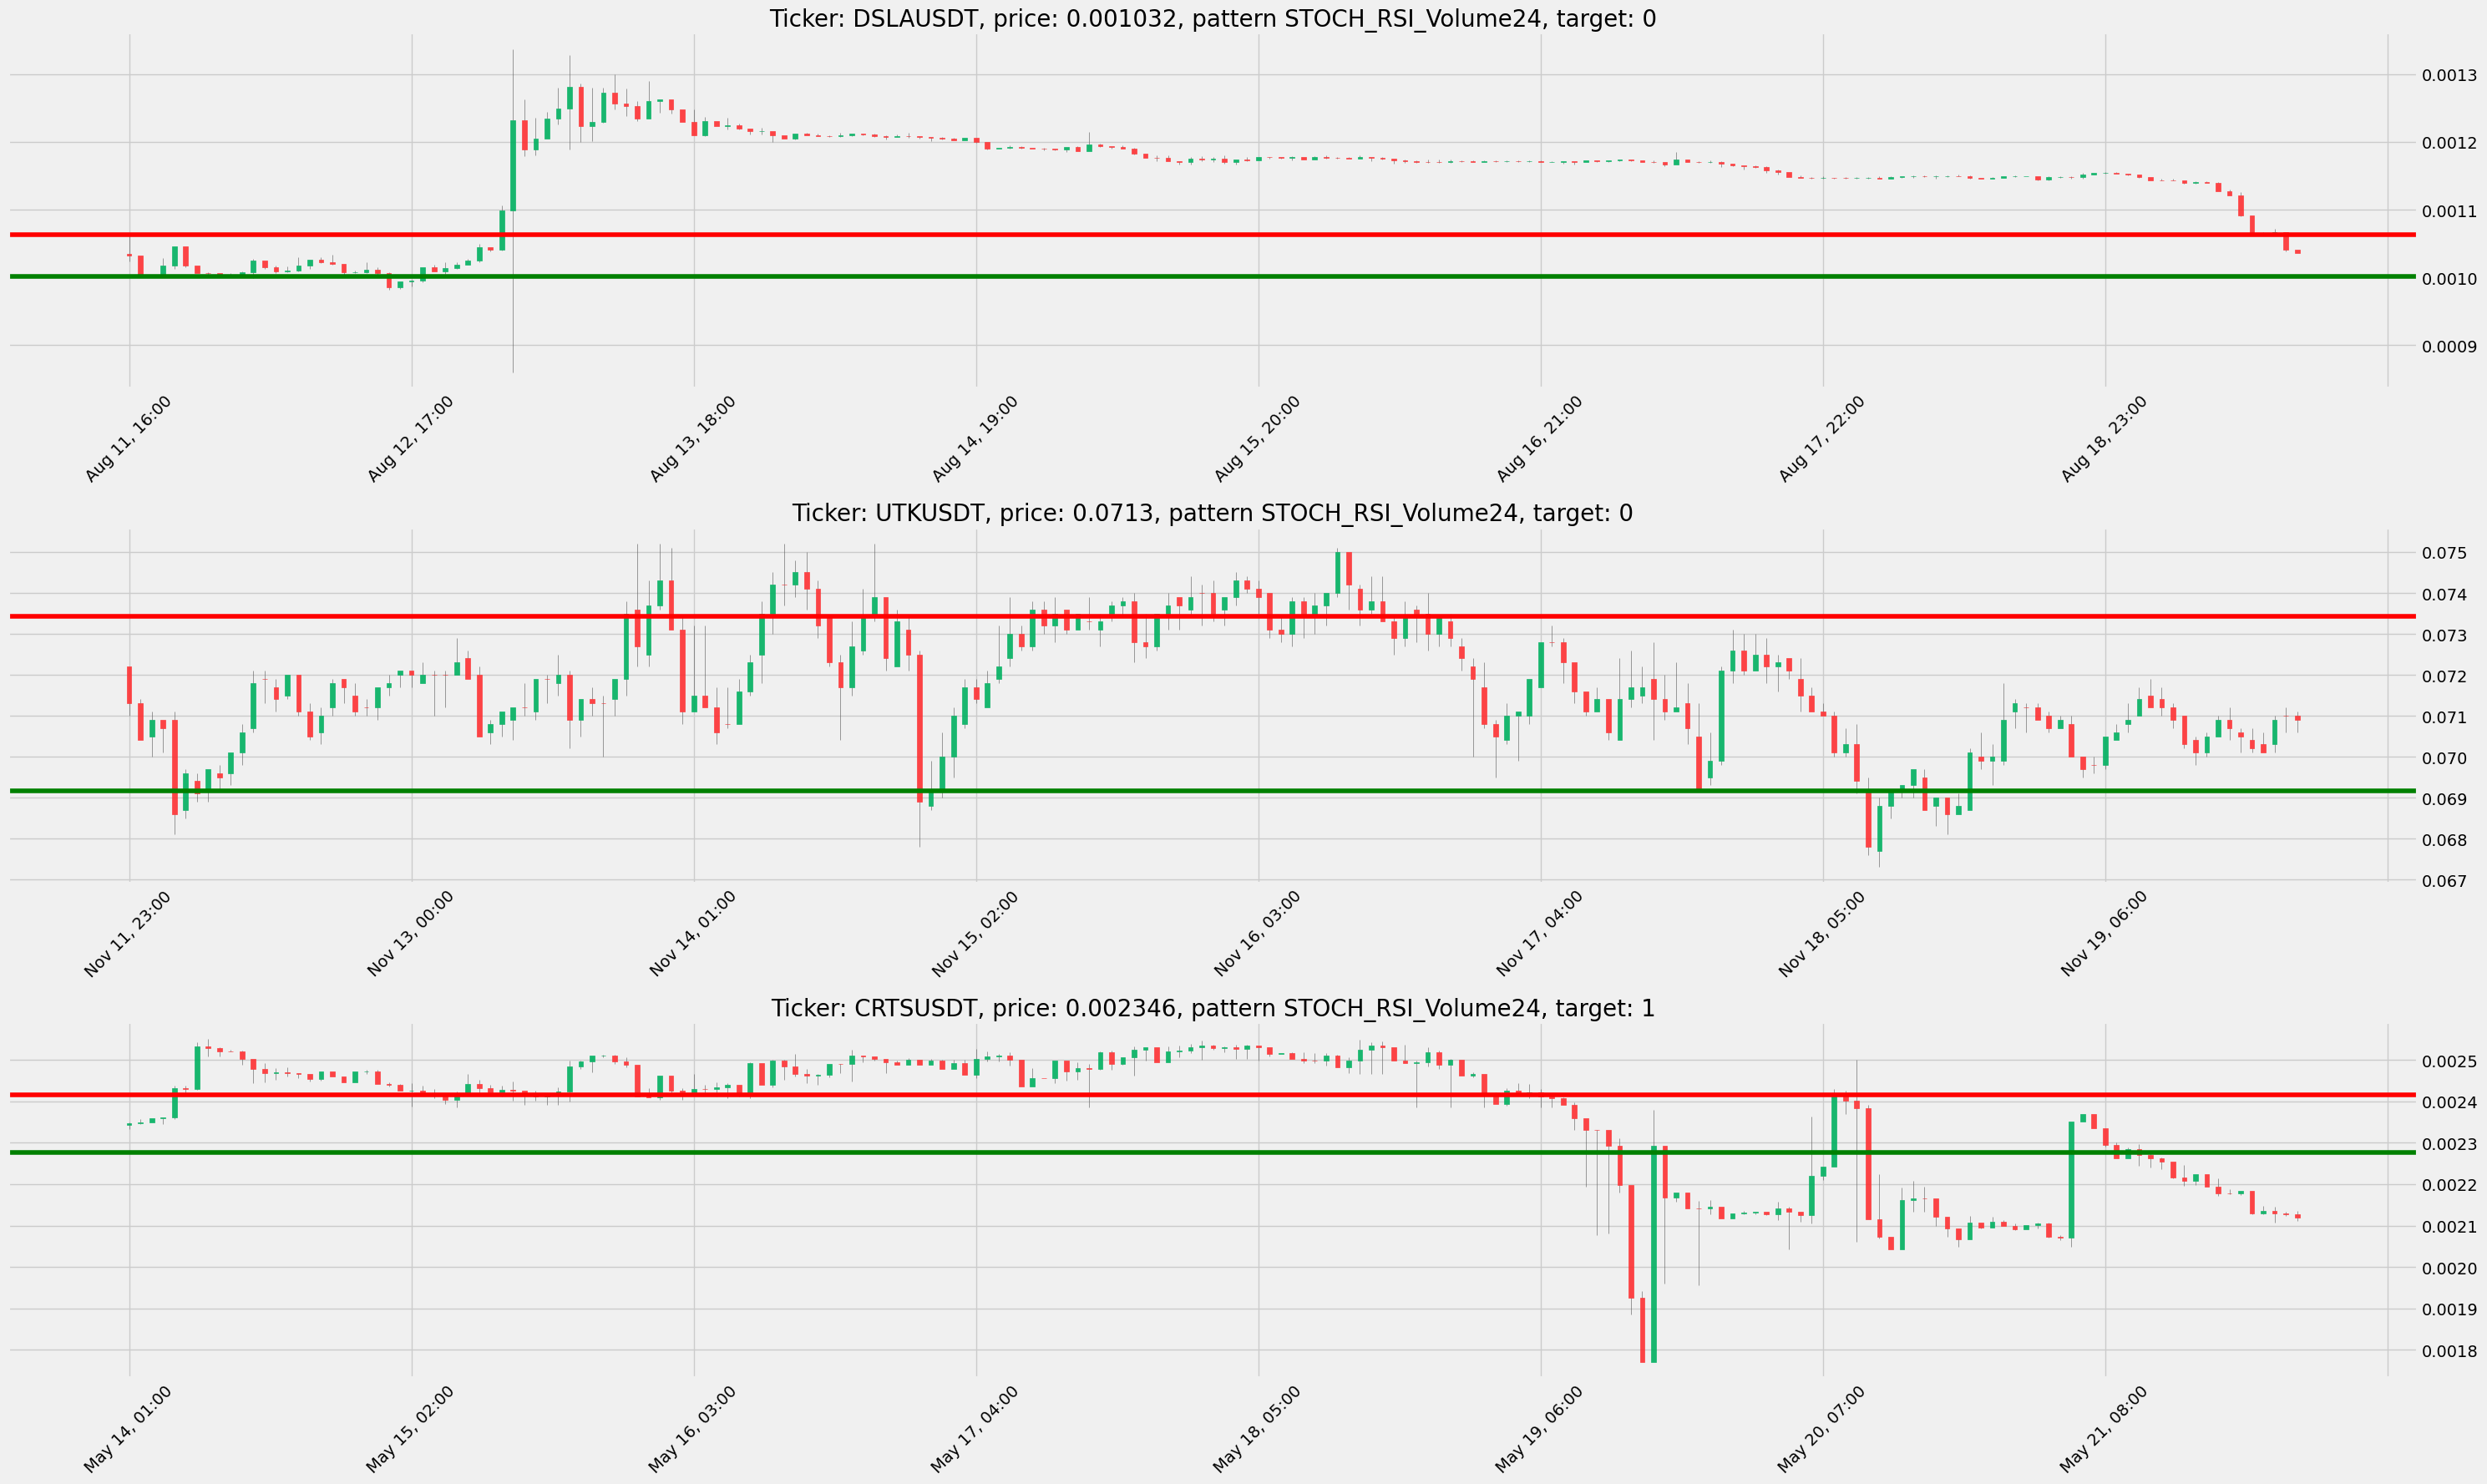

In [ ]:
if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_sell.index
    test_sell = train_sell.sample(plt_num, axis=0)

    for i, row in test_sell.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]
        
        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize feature distributions

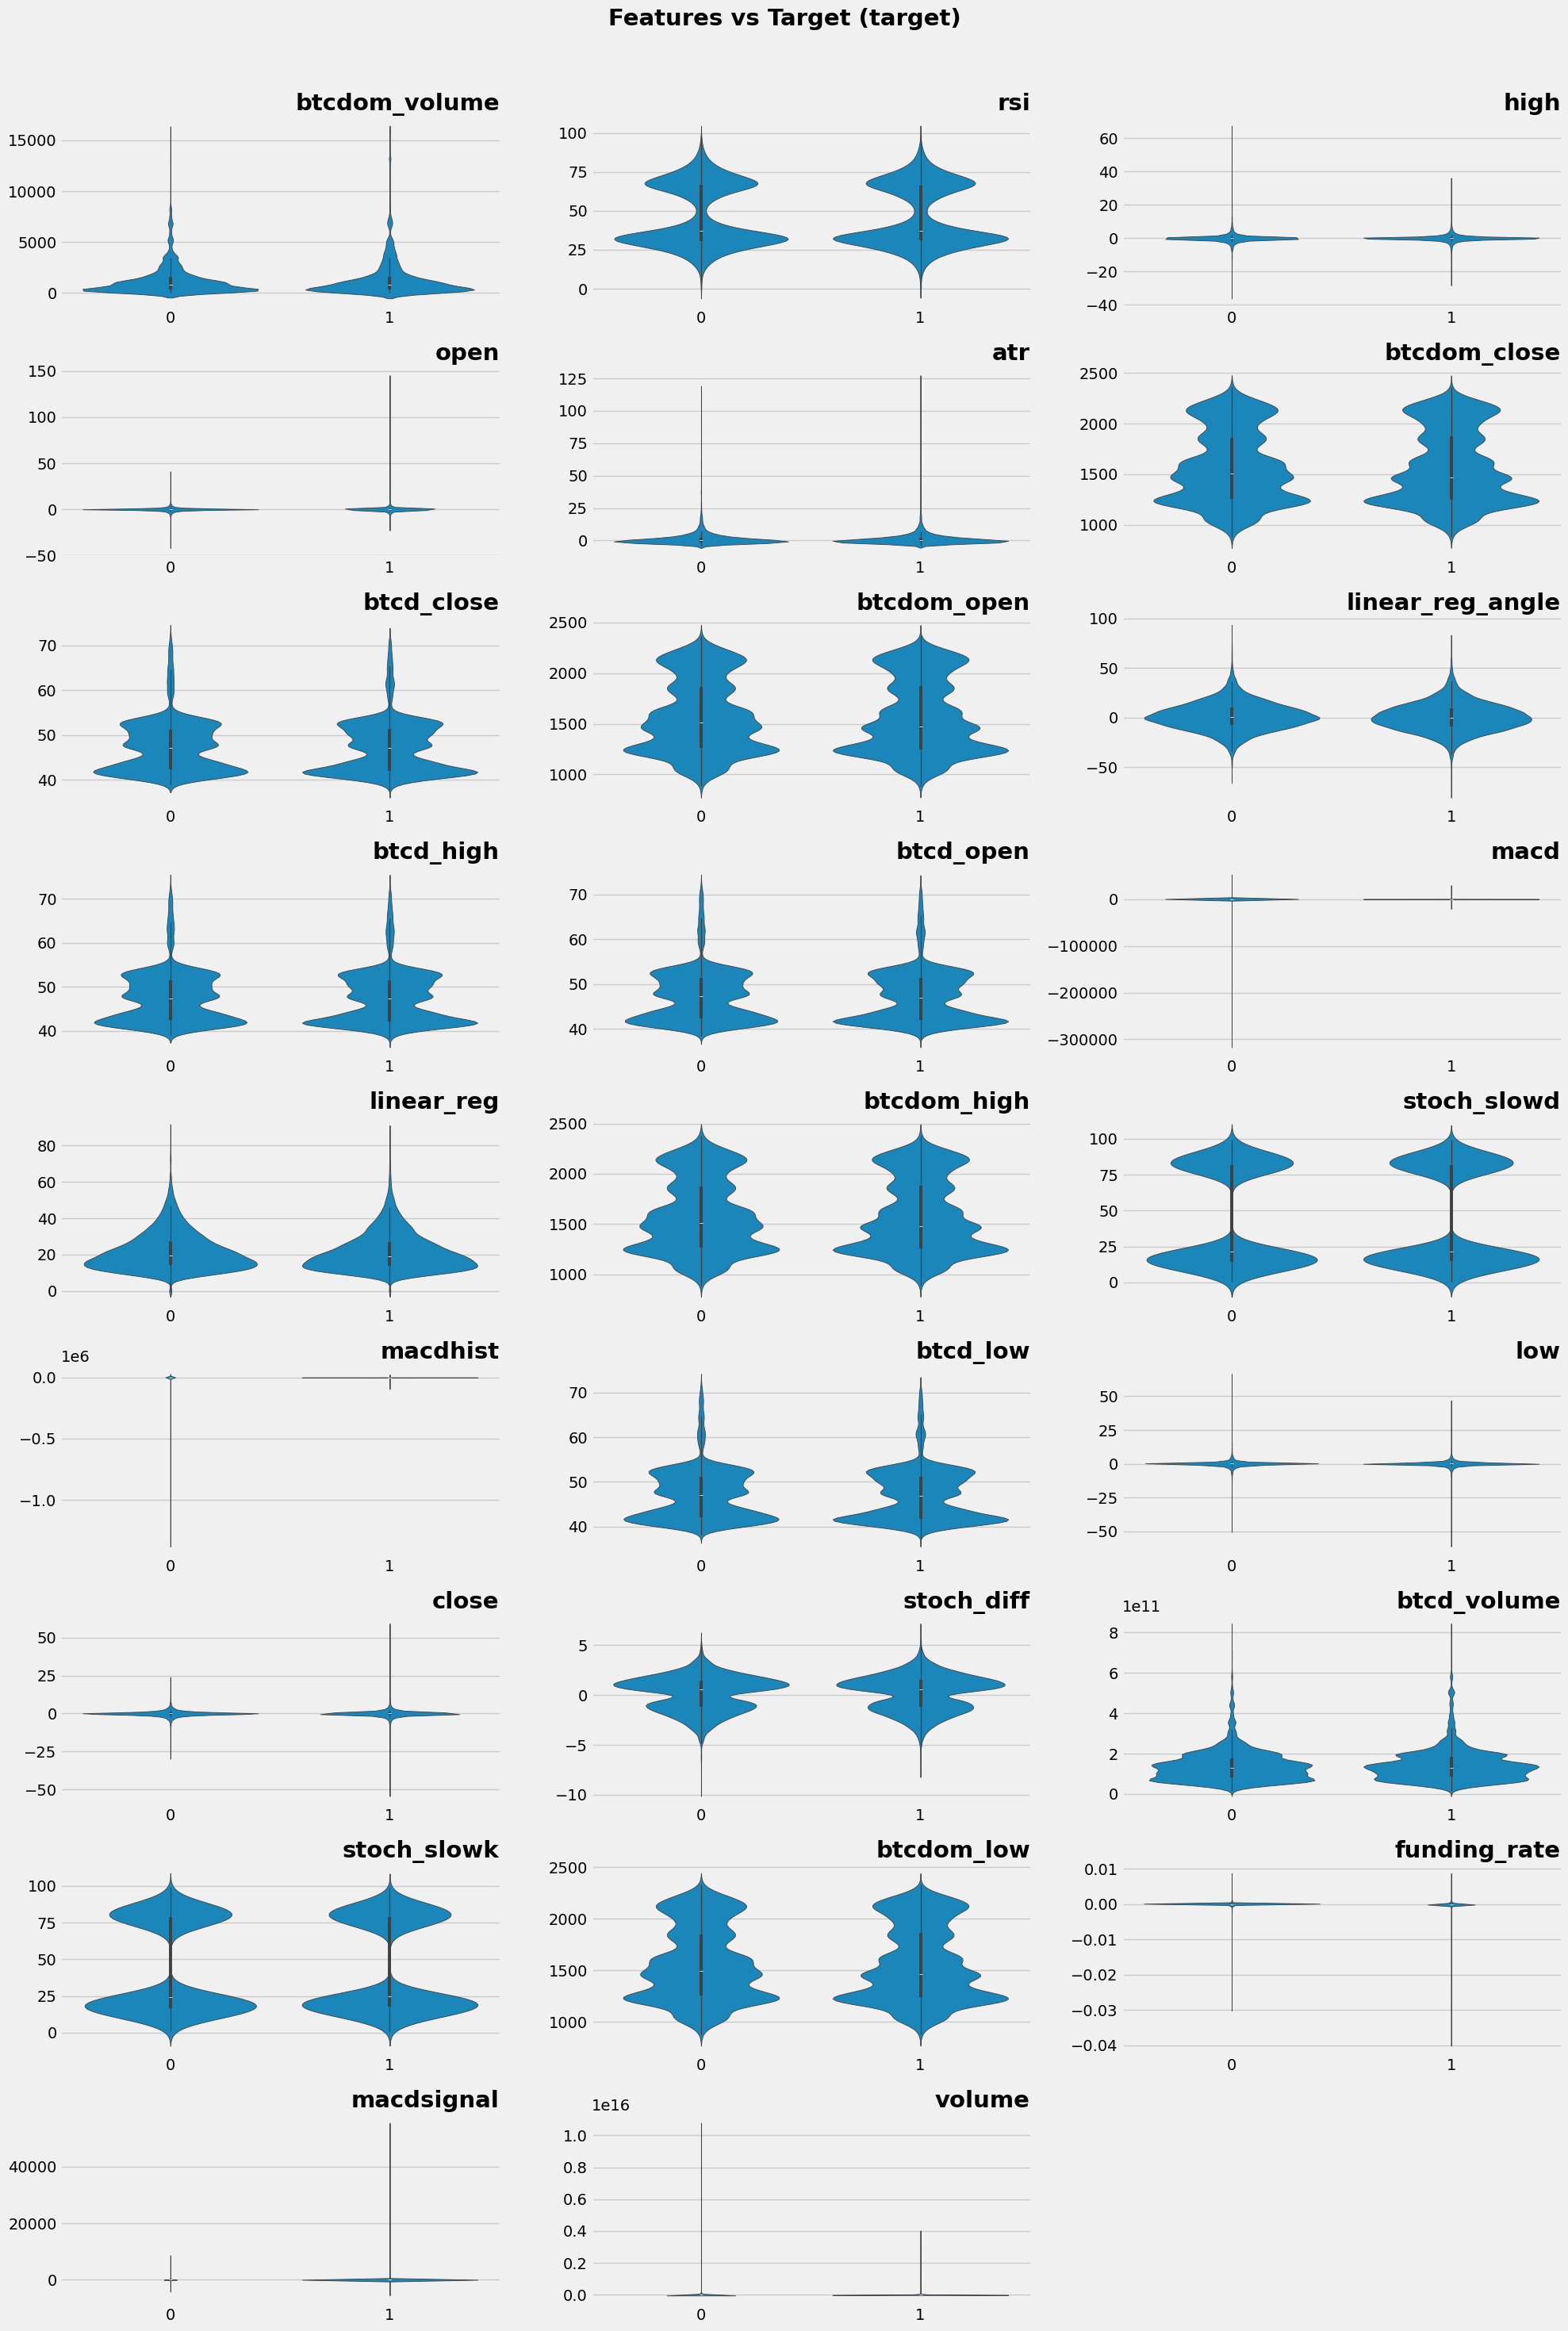

In [ ]:
fi = pd.read_csv(f'feature_importance.csv')['Feature'].to_list()
cols = [c for c in fi if 'prev' not in c]
figsize = (20, 30)

def plot_target_violine(df, df_cols, n_rows, n_cols, target):
    fig = plt.figure(figsize=figsize)
    
    for idx, col in enumerate(df_cols):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        try:
            sns.violinplot(x=target, y=col, data=df)
        except ValueError:
            print(f"Can't find {col} in the dataframe")

        ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
        ax.set_xlabel(''); ax.spines['right'].set_visible(False)
        ax.set_title(f'{col}', loc='right', weight='bold', fontsize=21)

    
    fig.suptitle(f'Features vs Target ({target})\n\n\n', ha='center',  fontweight='bold', fontsize=21)
    # fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
n_cols = 3
n_rows = len(cols) // n_cols + 1
plot_target_violine(train_df, cols, n_rows=n_rows, n_cols=n_cols, target='target') 

### Show the last signals

In [ ]:
x = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
x['ttype'] = 'buy'
y = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
y['ttype'] = 'sell'
x = pd.concat([x, y]).sort_values('time').reset_index(drop=True)
x.loc[x['pattern'] == 'STOCH_RSI_Volume24', ['time', 'ticker', 'ttype', 'pattern']].tail(30)

,time,ticker,ttype,pattern
73898,2024-03-01 19:00:00,BCUTUSDT,sell,STOCH_RSI_Volume24
73899,2024-03-01 20:00:00,ZETRIXUSDT,sell,STOCH_RSI_Volume24
73900,2024-03-01 20:00:00,HERUSDT,buy,STOCH_RSI_Volume24
73901,2024-03-01 20:00:00,DEBUSDT,buy,STOCH_RSI_Volume24
73902,2024-03-01 20:00:00,STGUSDT,sell,STOCH_RSI_Volume24
73903,2024-03-01 20:00:00,CADUSDT,buy,STOCH_RSI_Volume24
73904,2024-03-01 21:00:00,VAIUSDT,sell,STOCH_RSI_Volume24
73905,2024-03-01 21:00:00,NEXTUSDT,sell,STOCH_RSI_Volume24
73906,2024-03-01 21:00:00,ORTUSDT,sell,STOCH_RSI_Volume24
73907,2024-03-01 22:00:00,AIAUSDT,buy,STOCH_RSI_Volume24


# Feature selection

### Select features with BORUTA feature importance

In [ ]:
from shaphypetune import BoostBoruta
  
params = {
          'boosting_type': 'dart',
          'n_estimators': 1000,
          'learning_rate': 0.02,
          'max_depth': 10,
          'subsample' : 0.7,
          'colsample_bytree': 0.85,
          'num_leaves': 24,
          'verbosity': -1,
          'importance_type': 'gain',
          'max_bin': 255,
          'reg_alpha': 1e-6,
          'reg_lambda': 1e-7,
          'objective': 'binary',
          'metric': 'average_precision'
        }
features = [c for c in train_df.columns if c not in ['time', 'target', 'ticker', 'pattern', 'ttype']]



def boruta_selction(df):
    boruta_df_ = pd.DataFrame()

    X, y, time = df[features], df['target'], df['time']

    tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
    eval_metric = 'logloss'

    # Stratify based on Class and Alpha (3 types of conditions)
    for fold, (train_idx, val_idx) in enumerate(tss.split(time)):

        print(f'Fold: {fold}')
        # Split the dataset according to the fold indexes.
        X_train = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        clf = lgb.LGBMClassifier(**params)
        model = BoostBoruta(clf, importance_type='shap_importances', train_importance=False, max_iter=1000)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)],  
                  eval_metric='logloss', 
                  callbacks=[lgb.log_evaluation(100)])

        boruta_importance_df = pd.DataFrame({'importance': model.ranking_}, index=X_train.columns).sort_index()
        if boruta_df_.shape[0] == 0:
            boruta_df_ = boruta_importance_df.copy()
        else:
            boruta_df_ += boruta_importance_df

    boruta_df_ = boruta_df_.sort_values('importance')
    boruta_df_ = boruta_df_.reset_index().rename({'index': 'Feature'}, axis=1)

    return boruta_df_


if CFG.select_features:
    boruta_df_ = boruta_selction(train_df)

### Select features with permutation importance and GBM feature importance

In [ ]:
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

def lgbm_tuning(df, permut=False):
    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()
    
    for fold in range(CFG.n_repeats):
        print(f'Repeat {blu}#{fold+1}')

        X, y, time = df[features], df['target'], df['time']
        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
        eval_metric = 'logloss'
        
        oof = np.zeros(len(df))
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (train_idx, val_idx) in enumerate(tss.split(time)):
            if fold == 0:
                first_val_idx = val_idx[0]
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[train_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                    eval_metric=eval_metric, 
                    callbacks=[lgb.log_evaluation(100)])

            val_preds = clf.predict_proba(X_val)[:,1]
            val_score = log_loss(y_val, val_preds)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f'Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}')

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                      columns=['Value','Feature'])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_['Value'] += f_i['Value']
            
            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({'importance': perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

        outer_cv = log_loss(y[first_val_idx:], oof[first_val_idx:])
        outer_cv_score.append(outer_cv)

    print(f'{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}')
    print(f'{"*" * 50}\n')
    
    if permut:
        perm_df_ = perm_df_.sort_values('importance', ascending=False)
        perm_df_ = perm_df_.reset_index().rename({'index': 'Feature'}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values('Value', ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, np.mean(outer_cv_score)


if CFG.select_features:
    perm_df_, feature_importances_, outer_cv_score = lgbm_tuning(train_df, permut=True)

### RFE feature selection

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

def rfe_selection(df):
    params = {
          'penalty': 'l2',
          'max_iter': 10000,
          'C': 1
        }

    scaler = StandardScaler()
    X, y = df[features], df['target']
    X = scaler.fit_transform(X)
        
    estimator = LogisticRegression(**params)
    selector = RFECV(estimator, min_features_to_select=50, step=0.025, cv=5, verbose=1)
    selector = selector.fit(X, y)
    rfe_df_ = pd.DataFrame({'importance': selector.ranking_}, index=features).sort_index()
    rfe_df_ = rfe_df_.reset_index().rename({'index': 'Feature'}, axis=1)
    return rfe_df_

if CFG.select_features:
    rfe_df_ = rfe_selection(train_df)

### Combine importances and save them

In [ ]:
if CFG.select_features:
    perm_df_['rank'] = perm_df_['importance'].rank(ascending=False)
    boruta_df_['rank'] = boruta_df_['importance'].rank()
    rfe_df_['rank'] = rfe_df_['importance']
    feature_importances_['rank'] = feature_importances_['Value'].rank(ascending=False)

    fi = pd.concat([perm_df_[['Feature','rank']], feature_importances_[['Feature','rank']], rfe_df_[['Feature','rank']],#])
                    boruta_df_[['Feature','rank']]])
    fi = fi.groupby('Feature')['rank'].sum().sort_values().reset_index()
    fi.to_csv(f'feature_importance.csv')
else:
    fi = pd.read_csv(f'feature_importance.csv')

### Load selected features

In [ ]:
def prepare_features(fi, feature_num, features_to_exclude):
    ''' Get features, sort them by their time appearance and return for using in train and inference'''
    # exclude some features 
    fi = fi['Feature']
    fi = [f for f in fi if f not in features_to_exclude]
    fi = fi[:feature_num]
    feature_dict = defaultdict(list)
    features = list()
    
    for f in fi:
        if f == 'volume_24':
            feature_dict[0].append(f)
            continue
        period = f.split('_')
        if period[-1].isdigit():
            feature_dict[int(period[-1])].append('_'.join(period[:-2]))
        else:
            feature_dict[0].append(f)

    feature_dict = dict(sorted(feature_dict.items()))
    
    for item in feature_dict.items():
        if item[0] > 0:
            features.extend([i + f'_prev_{item[0]}' for i in item[1]])
        else:
            features.extend([i for i in item[1]])

    feature_dict['features'] = features # + ['Pattern_Trend', 'STOCH_RSI']

    return features, feature_dict

train_df['weekday'] = train_df['time'].dt.weekday
fi = pd.read_csv(f'feature_importance.csv')
feature_num = 96 # 64
features_to_exclude = []
features, feature_dict = prepare_features(fi, feature_num, features_to_exclude)
features = features + ['weekday']
display(features)

['btcdom_volume',
 'rsi',
 'high',
 'open',
 'atr',
 'btcdom_close',
 'btcd_close',
 'rsi_prev_4',
 'btcdom_close_prev_4',
 'stoch_diff_prev_4',
 'btcdom_volume_prev_4',
 'atr_prev_4',
 'rsi_prev_8',
 'stoch_diff_prev_8',
 'linear_reg_angle_prev_8',
 'stoch_slowd_prev_8',
 'high_prev_8',
 'btcdom_volume_prev_12',
 'low_prev_12',
 'btcdom_volume_prev_16',
 'rsi_prev_16',
 'stoch_diff_prev_24',
 'high_prev_24',
 'low_prev_24',
 'btcd_volume_prev_24',
 'btcdom_volume_prev_24',
 'stoch_diff_prev_28',
 'high_prev_28',
 'volume_prev_32',
 'low_prev_36',
 'atr_prev_40',
 'low_prev_40',
 'btcdom_volume_prev_44',
 'btcd_volume_prev_48',
 'close_prev_48',
 'open_prev_48',
 'high_prev_48',
 'stoch_diff_prev_52',
 'atr_prev_52',
 'stoch_diff_prev_56',
 'atr_prev_56',
 'btcdom_volume_prev_64',
 'high_prev_68',
 'low_prev_68',
 'btcdom_volume_prev_72',
 'btcd_volume_prev_72',
 'btcdom_volume_prev_80',
 'high_prev_80',
 'atr_prev_84',
 'btcdom_volume_prev_84',
 'rsi_prev_92',
 'close_prev_92',
 'stoc

### Show the features that correlate with other features too much (corr >= 0.8) and are not too important

In [ ]:
if CFG.select_features:
    features_to_select = features.copy()
    correlations = train_df.loc[:, features_to_select].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    correlations = correlations[correlations['level_0'] != correlations['level_1']] 
    correlations.columns = ['feature_1', 'feature_2', 'corr']

    correlations = pd.merge(left=correlations, right=fi, how='left', left_on='feature_1', right_on='Feature')
    correlations = correlations.drop(columns='Feature')
    correlations = correlations.sort_values(['rank', 'feature_1'])

    features_to_exclude = list()
    corr_thresh = 0.8

    for i, row in correlations.iterrows():
        feature_1 = row['feature_1']
        feature_2 = row['feature_2']
        corr = row['corr']

        if feature_1 in features_to_exclude:
            continue

        if corr > corr_thresh:
            features_to_exclude.append(feature_2)

    display(set(features_to_exclude))

# Train

### Functions for train and optimization

In [ ]:
val_idxs = list()
prec_score_list = list()
with open(f'bybit_tickers.json', 'r') as f:
    bybit_tickers = json.load(f)

def confident_score(y, oof, low_bound, high_bound):
    ''' Consider only high confident objects for accuracy and precision scores calculation;
        object probability must be lower than low_bound or higher than high_bound '''
    pred_conf = np.zeros_like(oof)
    pred_conf[oof > high_bound] = 1
    pred_conf_prec = pred_conf[(oof > high_bound)]
    y_conf_prec = y.values.reshape(-1,1)[(oof > high_bound)]
    if y_conf_prec.shape[0] == 0:
        return 0, 0, 0
    return precision_score(y_conf_prec, pred_conf_prec), y_conf_prec.shape[0], y_conf_prec.shape[0]/y.shape[0]

def model_train(df, features, params, n_folds, low_bound, high_bound, train_test, verbose=False): 
    X, time = df[features], df['time']
    y = df['target']
    
    if train_test == 'fold':
        oof = np.zeros([len(df), 1])

        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=n_folds, test_size=(len(df) * 2) // (n_folds * 3))

        if verbose:
            print(f"Training with {len(features)} features")
        
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_time = time[fit_idx].max() + pd.to_timedelta(96, unit='h')
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_time) & (df['ticker'].isin(bybit_tickers))].index.tolist()
            
            val_idxs.extend(val_idx)
            
            if verbose:
                print(f'Fold #{fold + 1}')
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            if verbose:
                display(y_val.value_counts(normalize=True))
                display(df.loc[val_idx[0], 'time'])
                display(df.loc[val_idx[-1], 'time'])
                callbacks = [lgb.log_evaluation(100)]
            else:
                callbacks = []
            
            model_lgb = lgb.LGBMClassifier(**params)
            model_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
                          eval_metric='logloss', callbacks=callbacks)

            val_preds = model_lgb.predict_proba(X_val)
        
            val_score = log_loss(y_val, val_preds)
            prec_score, prec_obj_num, prec_obj_pct = confident_score(y_val, val_preds[:, 1], low_bound, high_bound)
            prec_score_list.append(prec_score)
            if verbose:
                print(f'Logloss: {val_score}, Confident objects precision: {prec_score}\n'
                      f'Number of confident objects {prec_obj_num}, % of confident objects: {prec_obj_pct}\n'
                      f'Number of profitable objects: {round((2 * prec_score -  1) * prec_obj_num)}')
            oof[val_idx, 0] = val_preds[:,1]
        
        return oof, model_lgb, sorted(list(set(val_idxs)))
    elif train_test == 'full':
        print('Train on full data')
        X, y = df[features], df['target']
        
        model_lgb = lgb.LGBMClassifier(**params)
        model_lgb.fit(X, y, eval_set=[(X, y)], eval_metric='logloss', callbacks = [lgb.log_evaluation(100)])
        
        return np.zeros([df.shape[0], 1]), model_lgb, None

def objective(trial):
    params = {
        # Main parameters
#                     'device': 'gpu',
#                     'gpu_platform_id': 0,
#                     'gpu_device_id': 0,
        'objective': 'binary',
        'metric': 'average_precision',
        'boosting_type': trial.suggest_categorical('boosting_type', ['dart', 'goss', 'gbdt']),   
        # Hyperparamters (in order of importance decreasing)
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),  # max number of trees in model
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 3e-1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True), # L1,  alias: lambda_l1
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True), # L2, alias: lambda_l2
         # decrease to deal with overfit
        'max_depth': trial.suggest_int('max_depth', 4, 10),   # tree max depth 
         # decrease to deal with overfit
        'num_leaves': trial.suggest_int('num_leaves', 4, 512),  # Max number of leaves in one tree
                                                                # should be ~ 2**(max_depth-1)
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9), # Randomly select a subset of features 
                                                                   # if colsample_bytree < 1.0
                                                                   # alias:feature_fraction
        # increase for accuracy, decrease to deal with overfit
        'max_bin': trial.suggest_int('max_bin', 32, 255), # Max number of bins that feature values will be bucketed in
        # increase to deal with overfit
        'subsample_freq': 1, # Perform bagging at every k iteration, alias: bagging_freq

#           'subsample_for_bin': 200000, # Number of data that sampled to construct feature discrete bins; setting this 
                                     # to larger value will give better training result but may increase train time 
#           'cat_smooth': trial.suggest_float('cat_smooth', 10.0, 100.0),  # this can reduce the effect of noises in 
                                                                       # categorical features, especially for 
                                                                       # categories with few data
        'is_unbalance': trial.suggest_categorical('is_unbalance', [True, False]),                                                        
        'verbose': -1,
        
        'high_bound': 0.5,
        'feature_num': trial.suggest_int('feature_num', 50, 500),
        'importance_type': 'gain'
    }

    if params['is_unbalance'] is True:
        params['class_weight'] = 'balanced'
    
    if params['boosting_type'] != 'goss':
        params['subsample'] = trial.suggest_float('subsample', 0.3, 0.9)

    high_bound = params['high_bound']
    low_bound = 1 - high_bound
    del params['high_bound']
    
    fi = pd.read_csv(f'feature_importance.csv')
    feature_num = params['feature_num']
    del params['feature_num']
    
    train_df['weekday'] = train_df['time'].dt.weekday
    features_to_exclude = list()
    features, _ = prepare_features(fi, feature_num, features_to_exclude)
    features = features + ['weekday']
    
    oof, __, val_idxs = model_train(train_df, features, params, n_folds=8, low_bound=low_bound, high_bound=high_bound, 
                                    train_test='fold')
    y = train_df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)
    oof_val_score = log_loss(y, oof)
    res = oof_conf_obj_num * (oof_conf_prec_score-0.55) * 100
    # save dataframe with additional information
    df_optuna_more_info = pd.read_csv('optuna_lgbm_info.csv')
    profit_objects = round(oof_conf_obj_num * (2 * oof_conf_prec_score - 1))
    tmp = pd.DataFrame({'value': [res], 'oof_conf_prec_score': [oof_conf_prec_score], 
                        'profit_objects': [profit_objects], 'oof_val_score': [oof_val_score], 
                        'oof_conf_obj_num': [oof_conf_obj_num], 'oof_conf_obj_pct': [oof_conf_obj_pct], 
                        })
    df_optuna_more_info = pd.concat([df_optuna_more_info, tmp])
    df_optuna_more_info.to_csv('optuna_lgbm_info.csv', index=False)
    return res

### Train / optimize process

In [ ]:
# params = {
#     'boosting_type': 'gbdt',
#     'n_estimators': 2029,
#     'learning_rate': 0.0029802079941887525,
#     'reg_alpha': 0.0003050568761042403,
#     'reg_lambda': 1.602614646722288e-05,
#     'max_depth': 4,
#     'num_leaves': 500,
#     'colsample_bytree': 0.8644932085440681,
#     'max_bin': 73,
#     'is_unbalance': True,
#     'class_weight': 'balanced',
#     'feature_num': 64,
#     'subsample_freq': 1,
#     'subsample': 0.3281862009667817,
#     'objective': 'binary',
#     'importance_type': 'gain',
#     'metric': 'average_precision',
#     'verbosity': -1
#     }

params = {
            'boosting_type': 'gbdt',
            'n_estimators': 981,
            'learning_rate': 0.000704494362894,
            'is_unbalance': True,
            'class_weight': 'balanced',
            'colsample_bytree': 0.6866010952449154,
            'subsample': 0.4389198432764489,
            'max_depth': 4,
            'num_leaves': 35,
            'max_bin': 58,
            'reg_alpha': 0.0002065499898305,
            'reg_lambda': 4.257519867834792e-05,
            'subsample_freq': 1,
            'objective': 'binary',
            'importance_type': 'gain',
            'metric': 'average_precision',
            'verbosity': -1
        }

train_test = 'full' # fold, full
high_bound = 0.5
low_bound = 1 - high_bound
last_date = '2024-01-28'

if CFG.optimize:
    df_optuna_more_info = pd.DataFrame(columns=['value', 'oof_conf_prec_score', 'profit_objects', 
                                                'oof_val_score', 'oof_conf_obj_num', 'oof_conf_obj_pct'])
    df_optuna_more_info.to_csv('optuna_lgbm_info.csv', index=False)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=500)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    df_optuna = study.trials_dataframe()
    df_optuna = df_optuna.sort_values('value', ascending=False)
    df_optuna.to_csv(f'optuna_lgbm.csv')

    display(df_optuna.head(10))
elif train_test == 'fold':
    # fold
    oof, _, val_idxs = model_train(train_df, features, params, n_folds=8, low_bound=low_bound, high_bound=high_bound, 
                                   train_test=train_test, verbose=True)
    y = train_df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_val_score = log_loss(y, oof)
    oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)

    print(f'Total fold Logloss: {oof_val_score}, Total confident objects precision: {oof_conf_prec_score}\n'
            f'Number of confident objects: {oof_conf_obj_num}, Total % of confident objects: {oof_conf_obj_pct}\n' 
            f'Number of profitable objects: {round(( 2 * oof_conf_prec_score - 1) * oof_conf_obj_num)}')
# elif train_test == 'full': TODO uncomment this when end testing
#     oof, model, val_idxs = model_train(train_df[train_df['time'] < last_date], features, params, n_folds=5, low_bound=low_bound, 
#                                        high_bound=high_bound, train_test=train_test, verbose=True)
#     joblib.dump(model, f'lgbm.pkl')
#     # save feature dictionary for further inference
#     with open(f'features.json', 'w') as f:
#         json.dump(feature_dict, f)

### Visualize train results

In [ ]:
if train_test == 'fold':
    sns.lineplot(x=list(range(1, 9)), y=prec_score_list)

    plt.title('Model precision score by folds')
    plt.xlabel('Folds')
    plt.xticks(fontsize=12)
    plt.ylabel('Precision score')
    plt.yticks(fontsize=12)

    plt.show()

### Distribution of model prediction scores

In [ ]:
if train_test == 'fold':
    sns.displot(oof)

    plt.xlabel('Model prediction scores')
    plt.xticks(fontsize=10)
    plt.ylabel('Number of predictions')
    plt.yticks(fontsize=10)

In [ ]:
# Training with 97 features
# Fold #1
# 1    0.539566
# 0    0.460434
# Name: target, dtype: float64Timestamp('2022-06-25 01:00:00')Timestamp('2024-02-26 17:00:00')
# [100]	training's binary_logloss: 0.688241	training's average_precision: 0.73202	valid_1's binary_logloss: 0.69275	valid_1's average_precision: 0.592381
# [200]	training's binary_logloss: 0.683617	training's average_precision: 0.735244	valid_1's binary_logloss: 0.692923	valid_1's average_precision: 0.589755
# [300]	training's binary_logloss: 0.679462	training's average_precision: 0.738759	valid_1's binary_logloss: 0.692901	valid_1's average_precision: 0.59055
# [400]	training's binary_logloss: 0.675632	training's average_precision: 0.740985	valid_1's binary_logloss: 0.692861	valid_1's average_precision: 0.590875
# [500]	training's binary_logloss: 0.67217	training's average_precision: 0.744534	valid_1's binary_logloss: 0.693151	valid_1's average_precision: 0.590368
# [600]	training's binary_logloss: 0.668853	training's average_precision: 0.746852	valid_1's binary_logloss: 0.692991	valid_1's average_precision: 0.591311
# [700]	training's binary_logloss: 0.665729	training's average_precision: 0.74893	valid_1's binary_logloss: 0.693111	valid_1's average_precision: 0.59188
# [800]	training's binary_logloss: 0.662737	training's average_precision: 0.751948	valid_1's binary_logloss: 0.693046	valid_1's average_precision: 0.591403
# [900]	training's binary_logloss: 0.660066	training's average_precision: 0.754735	valid_1's binary_logloss: 0.693225	valid_1's average_precision: 0.591505
# Logloss: 0.6933648865584541, Confident objects precision: 0.5859717486604968
# Number of confident objects 2053, % of confident objects: 0.26076463863838434
# Number of profitable objects: 353
# Fold #2
# 1    0.545652
# 0    0.454348
# Name: target, dtype: float64Timestamp('2022-09-19 01:00:00')Timestamp('2024-02-26 17:00:00')
# [100]	training's binary_logloss: 0.688653	training's average_precision: 0.712109	valid_1's binary_logloss: 0.692905	valid_1's average_precision: 0.603906
# [200]	training's binary_logloss: 0.684474	training's average_precision: 0.71783	valid_1's binary_logloss: 0.692838	valid_1's average_precision: 0.603489
# [300]	training's binary_logloss: 0.680582	training's average_precision: 0.722506	valid_1's binary_logloss: 0.69282	valid_1's average_precision: 0.600173
# [400]	training's binary_logloss: 0.677067	training's average_precision: 0.725024	valid_1's binary_logloss: 0.693067	valid_1's average_precision: 0.599526
# [500]	training's binary_logloss: 0.673723	training's average_precision: 0.727158	valid_1's binary_logloss: 0.693008	valid_1's average_precision: 0.600391
# [600]	training's binary_logloss: 0.670593	training's average_precision: 0.728989	valid_1's binary_logloss: 0.693157	valid_1's average_precision: 0.60047
# [700]	training's binary_logloss: 0.667686	training's average_precision: 0.731079	valid_1's binary_logloss: 0.693316	valid_1's average_precision: 0.600828
# [800]	training's binary_logloss: 0.664965	training's average_precision: 0.733301	valid_1's binary_logloss: 0.693239	valid_1's average_precision: 0.600805
# [900]	training's binary_logloss: 0.662455	training's average_precision: 0.735707	valid_1's binary_logloss: 0.693338	valid_1's average_precision: 0.601001
# Logloss: 0.693522569682079, Confident objects precision: 0.5962355798421373
# Number of confident objects 1647, % of confident objects: 0.23869565217391303
# Number of profitable objects: 317
# Fold #3
# 1    0.534131
# 0    0.465869
# Name: target, dtype: float64Timestamp('2023-01-07 04:00:00')Timestamp('2024-02-26 17:00:00')
# [100]	training's binary_logloss: 0.688856	training's average_precision: 0.71235	valid_1's binary_logloss: 0.692625	valid_1's average_precision: 0.563459
# [200]	training's binary_logloss: 0.684898	training's average_precision: 0.716818	valid_1's binary_logloss: 0.692304	valid_1's average_precision: 0.562338
# [300]	training's binary_logloss: 0.681214	training's average_precision: 0.720355	valid_1's binary_logloss: 0.692149	valid_1's average_precision: 0.559084
# [400]	training's binary_logloss: 0.677785	training's average_precision: 0.722436	valid_1's binary_logloss: 0.692038	valid_1's average_precision: 0.556606
# [500]	training's binary_logloss: 0.674694	training's average_precision: 0.724418	valid_1's binary_logloss: 0.691833	valid_1's average_precision: 0.55758
# [600]	training's binary_logloss: 0.671752	training's average_precision: 0.726215	valid_1's binary_logloss: 0.691679	valid_1's average_precision: 0.55892
# [700]	training's binary_logloss: 0.669013	training's average_precision: 0.727982	valid_1's binary_logloss: 0.691459	valid_1's average_precision: 0.560528
# [800]	training's binary_logloss: 0.66643	training's average_precision: 0.73014	valid_1's binary_logloss: 0.691271	valid_1's average_precision: 0.561181
# [900]	training's binary_logloss: 0.664036	training's average_precision: 0.732399	valid_1's binary_logloss: 0.69114	valid_1's average_precision: 0.561996
# Logloss: 0.6911192984568261, Confident objects precision: 0.5621074668527565
# Number of confident objects 2866, % of confident objects: 0.48306084611495026
# Number of profitable objects: 356
# Fold #4
# 1    0.544155
# 0    0.455845
# Name: target, dtype: float64Timestamp('2023-04-07 14:00:00')Timestamp('2024-02-26 17:00:00')
# [100]	training's binary_logloss: 0.689012	training's average_precision: 0.704872	valid_1's binary_logloss: 0.692981	valid_1's average_precision: 0.575211
# [200]	training's binary_logloss: 0.685163	training's average_precision: 0.708541	valid_1's binary_logloss: 0.692646	valid_1's average_precision: 0.591003
# [300]	training's binary_logloss: 0.681668	training's average_precision: 0.711183	valid_1's binary_logloss: 0.692635	valid_1's average_precision: 0.589911
# [400]	training's binary_logloss: 0.678458	training's average_precision: 0.71382	valid_1's binary_logloss: 0.692607	valid_1's average_precision: 0.589852
# [500]	training's binary_logloss: 0.675472	training's average_precision: 0.716024	valid_1's binary_logloss: 0.692722	valid_1's average_precision: 0.589074
# [600]	training's binary_logloss: 0.672603	training's average_precision: 0.71691	valid_1's binary_logloss: 0.692768	valid_1's average_precision: 0.589904
# [700]	training's binary_logloss: 0.669963	training's average_precision: 0.718754	valid_1's binary_logloss: 0.692842	valid_1's average_precision: 0.589483
# [800]	training's binary_logloss: 0.667486	training's average_precision: 0.719702	valid_1's binary_logloss: 0.692947	valid_1's average_precision: 0.589793
# [900]	training's binary_logloss: 0.665143	training's average_precision: 0.721677	valid_1's binary_logloss: 0.69321	valid_1's average_precision: 0.587656
# Logloss: 0.6933557014149222, Confident objects precision: 0.5969387755102041
# Number of confident objects 1176, % of confident objects: 0.24726661059714045
# Number of profitable objects: 228
# Fold #5
# 1    0.561081
# 0    0.438919
# Name: target, dtype: float64Timestamp('2023-06-10 16:00:00')Timestamp('2024-02-26 17:00:00')
# [100]	training's binary_logloss: 0.689115	training's average_precision: 0.706426	valid_1's binary_logloss: 0.692998	valid_1's average_precision: 0.5608
# [200]	training's binary_logloss: 0.685429	training's average_precision: 0.707422	valid_1's binary_logloss: 0.692939	valid_1's average_precision: 0.552561
# [300]	training's binary_logloss: 0.682073	training's average_precision: 0.71086	valid_1's binary_logloss: 0.692547	valid_1's average_precision: 0.554847
# [400]	training's binary_logloss: 0.678886	training's average_precision: 0.712542	valid_1's binary_logloss: 0.692146	valid_1's average_precision: 0.554665
# [500]	training's binary_logloss: 0.676004	training's average_precision: 0.71442	valid_1's binary_logloss: 0.692178	valid_1's average_precision: 0.552656
# [600]	training's binary_logloss: 0.673247	training's average_precision: 0.715852	valid_1's binary_logloss: 0.691925	valid_1's average_precision: 0.55433
# [700]	training's binary_logloss: 0.670658	training's average_precision: 0.717691	valid_1's binary_logloss: 0.691947	valid_1's average_precision: 0.553983
# [800]	training's binary_logloss: 0.668234	training's average_precision: 0.718843	valid_1's binary_logloss: 0.691761	valid_1's average_precision: 0.555037
# [900]	training's binary_logloss: 0.665906	training's average_precision: 0.720899	valid_1's binary_logloss: 0.691458	valid_1's average_precision: 0.556733
# Logloss: 0.6913680487103319, Confident objects precision: 0.5550474850510024
# Number of confident objects 2843, % of confident objects: 0.7683783783783784
# Number of profitable objects: 313
# Fold #6
# 1    0.568312
# 0    0.431688
# Name: target, dtype: float64Timestamp('2023-08-29 16:00:00')Timestamp('2024-02-26 17:00:00')
# [100]	training's binary_logloss: 0.689554	training's average_precision: 0.704743	valid_1's binary_logloss: 0.693061	valid_1's average_precision: 0.61121
# [200]	training's binary_logloss: 0.686165	training's average_precision: 0.706922	valid_1's binary_logloss: 0.693163	valid_1's average_precision: 0.607246
# [300]	training's binary_logloss: 0.683086	training's average_precision: 0.709283	valid_1's binary_logloss: 0.693165	valid_1's average_precision: 0.613652
# [400]	training's binary_logloss: 0.680176	training's average_precision: 0.711855	valid_1's binary_logloss: 0.693166	valid_1's average_precision: 0.614827
# [500]	training's binary_logloss: 0.677513	training's average_precision: 0.714011	valid_1's binary_logloss: 0.693223	valid_1's average_precision: 0.614832
# [600]	training's binary_logloss: 0.674959	training's average_precision: 0.714905	valid_1's binary_logloss: 0.693179	valid_1's average_precision: 0.612528
# [700]	training's binary_logloss: 0.67259	training's average_precision: 0.715753	valid_1's binary_logloss: 0.693188	valid_1's average_precision: 0.612186
# [800]	training's binary_logloss: 0.670294	training's average_precision: 0.717282	valid_1's binary_logloss: 0.693223	valid_1's average_precision: 0.612351
# [900]	training's binary_logloss: 0.66817	training's average_precision: 0.719205	valid_1's binary_logloss: 0.693243	valid_1's average_precision: 0.612432
# Logloss: 0.693253220444843, Confident objects precision: 0.6437941473259334
# Number of confident objects 991, % of confident objects: 0.3544349070100143
# Number of profitable objects: 285
# Fold #7
# 1    0.560458
# 0    0.439542
# Name: target, dtype: float64Timestamp('2023-11-15 18:00:00')Timestamp('2024-02-26 17:00:00')
# [100]	training's binary_logloss: 0.690072	training's average_precision: 0.69311	valid_1's binary_logloss: 0.69324	valid_1's average_precision: 0.62673
# [200]	training's binary_logloss: 0.687172	training's average_precision: 0.695624	valid_1's binary_logloss: 0.693118	valid_1's average_precision: 0.631837
# [300]	training's binary_logloss: 0.68445	training's average_precision: 0.69822	valid_1's binary_logloss: 0.693155	valid_1's average_precision: 0.629512
# [400]	training's binary_logloss: 0.681958	training's average_precision: 0.700114	valid_1's binary_logloss: 0.693139	valid_1's average_precision: 0.632291
# [500]	training's binary_logloss: 0.67966	training's average_precision: 0.701809	valid_1's binary_logloss: 0.693107	valid_1's average_precision: 0.634486
# [600]	training's binary_logloss: 0.677491	training's average_precision: 0.703315	valid_1's binary_logloss: 0.69306	valid_1's average_precision: 0.634317
# [700]	training's binary_logloss: 0.675356	training's average_precision: 0.704631	valid_1's binary_logloss: 0.692899	valid_1's average_precision: 0.635207
# [800]	training's binary_logloss: 0.673369	training's average_precision: 0.706362	valid_1's binary_logloss: 0.692858	valid_1's average_precision: 0.634595
# [900]	training's binary_logloss: 0.67159	training's average_precision: 0.708255	valid_1's binary_logloss: 0.692735	valid_1's average_precision: 0.634861
# Logloss: 0.6926254806505807, Confident objects precision: 0.6078431372549019
# Number of confident objects 510, % of confident objects: 0.2922636103151863
# Number of profitable objects: 110
# Fold #8
# 1    0.569067
# 0    0.430933
# Name: target, dtype: float64Timestamp('2024-01-13 23:00:00')Timestamp('2024-02-26 17:00:00')
# [100]	training's binary_logloss: 0.69027	training's average_precision: 0.683953	valid_1's binary_logloss: 0.692945	valid_1's average_precision: 0.653939
# [200]	training's binary_logloss: 0.687563	training's average_precision: 0.684357	valid_1's binary_logloss: 0.692517	valid_1's average_precision: 0.66396
# [300]	training's binary_logloss: 0.685091	training's average_precision: 0.686631	valid_1's binary_logloss: 0.692173	valid_1's average_precision: 0.664096
# [400]	training's binary_logloss: 0.682817	training's average_precision: 0.687935	valid_1's binary_logloss: 0.691859	valid_1's average_precision: 0.662029
# [500]	training's binary_logloss: 0.680716	training's average_precision: 0.690412	valid_1's binary_logloss: 0.69155	valid_1's average_precision: 0.662141
# [600]	training's binary_logloss: 0.678726	training's average_precision: 0.692389	valid_1's binary_logloss: 0.691284	valid_1's average_precision: 0.662069
# [700]	training's binary_logloss: 0.676799	training's average_precision: 0.693929	valid_1's binary_logloss: 0.691309	valid_1's average_precision: 0.659425
# [800]	training's binary_logloss: 0.675024	training's average_precision: 0.695912	valid_1's binary_logloss: 0.691255	valid_1's average_precision: 0.659048
# [900]	training's binary_logloss: 0.673334	training's average_precision: 0.697605	valid_1's binary_logloss: 0.691064	valid_1's average_precision: 0.661539
# Logloss: 0.6908991275249158, Confident objects precision: 0.6754716981132075
# Number of confident objects 265, % of confident objects: 0.31286894923258557
# Number of profitable objects: 93
# Total fold Logloss: 0.6922168813303121, Total confident objects precision: 0.6246786632390745
# Number of confident objects: 2334, Total % of confident objects: 0.29645624285532834
# Number of profitable objects: 582

# Test model

### Test model predictions on the new data

In [ ]:
if not CFG.optimize and train_test == 'full':
    model_lgb = joblib.load('lgbm.pkl')

    with open(f'bybit_tickers.json', 'r') as f:
        bybit_tickers = json.load(f)

    X = train_df[(train_df['ticker'].isin(bybit_tickers))]
    X['pred'] = model_lgb.predict_proba(X[features])[:,1]
    res = X.loc[(X['pred'] >= 0) & (X['time'] >= last_date), ['time', 'ticker', 'ttype', 'pred', 'target', 'pattern']]
    display(res['time'].min(), res['time'].max())
    display(res['target'].value_counts())
    display(res['target'].value_counts(normalize=True))

Timestamp('2024-01-28 01:00:00')

Timestamp('2024-03-01 19:00:00')

1    341
0    294
Name: target, dtype: int64

1    0.537008
0    0.462992
Name: target, dtype: float64

In [ ]:
# 1    84
# 0    53
# Name: target, dtype: int641    0.613139
# 0    0.386861
# Name: target, dtype: float64

In [ ]:
res.tail(100)

,time,ticker,ttype,pred,target,pattern
22360,2024-02-24 16:00:00,HOOKUSDT,sell,0.502193,0,STOCH_RSI_Volume24
22365,2024-02-24 17:00:00,IOTXUSDT,sell,0.507933,1,STOCH_RSI_Volume24
22367,2024-02-24 17:00:00,YFIUSDT,sell,0.505901,0,STOCH_RSI_Volume24
22370,2024-02-24 17:00:00,BALUSDT,sell,0.501384,1,STOCH_RSI_Volume24
22371,2024-02-24 18:00:00,THETAUSDT,sell,0.501714,1,STOCH_RSI_Volume24
22373,2024-02-24 18:00:00,ONEUSDT,sell,0.502767,1,STOCH_RSI_Volume24
22375,2024-02-24 18:00:00,WOOUSDT,sell,0.504135,1,STOCH_RSI_Volume24
22376,2024-02-24 18:00:00,FXSUSDT,sell,0.510121,0,STOCH_RSI_Volume24
22377,2024-02-24 18:00:00,FITFIUSDT,sell,0.503984,0,STOCH_RSI_Volume24
22378,2024-02-24 18:00:00,ZILUSDT,sell,0.509731,1,STOCH_RSI_Volume24


### Display PR curve

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

if not CFG.optimize and train_test == 'fold':
    disp = PrecisionRecallDisplay.from_predictions(
        y.values, oof, name="PR AUC"
    )
    plt.legend(loc='upper right')
    _ = disp.ax_.set_title("2-class Precision-Recall curve")
    disp.ax_.lines[0].set_linewidth(2)

# vol 1e6 AP=0.61

### Find the best threshold

In [ ]:
from icecream import ic

if not CFG.optimize and train_test == 'fold':
    prec_score_list = list()
    obj_num_list = list()
    obj_pct_list = list()
    obj_profit_list = list()
    max_obj_profit = 0
    for hb in np.arange(0.3, 0.75, 0.01):
        prec_score, obj_num, obj_pct = confident_score(y.reset_index(drop=True), oof, 1-hb, hb)
        if prec_score == 0:
            obj_num = 0
            obj_pct = 0
        bound, prec_score, obj_num, obj_pct = round(hb, 2), round(prec_score, 5), round(obj_num, 2), round(obj_pct, 2)
        obj_profit = round((2 * prec_score - 1) * obj_num)
        prec_score_list.append(prec_score)
        obj_num_list.append(obj_num)
        obj_pct_list.append(obj_pct)
        obj_profit_list.append(obj_profit)
        max_obj_profit = max(max_obj_profit, obj_profit)
        ic(bound, prec_score, obj_num, obj_pct, obj_profit)

    obj_profit_list = [o / max_obj_profit for o in obj_profit_list]
    line1 = plt.plot(np.arange(0.3, 0.75, 0.01), prec_score_list, label='precison score', linewidth=2)
    line2 = plt.plot(np.arange(0.3, 0.75, 0.01), obj_pct_list, label='object pct', linewidth=2)
    line3 = plt.plot(np.arange(0.3, 0.75, 0.01), obj_profit_list, label='number of profit objects', linewidth=2)
    plt.legend()
    plt.xlabel("Threshold")
    plt.show()

# Compare indicator / signal values for bot and optimizer

In [ ]:
# import pandas as pd
# from signals.find_signal import SignalFactory

# ttype = 'buy'
# ticker = 'METHUSDT'
# month = 1
# day = 25
# hour = 6
# configs = ConfigFactory.factory(environ).configs

# x = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_1h_{ttype}_{month}_{day}_{hour}.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)
# y = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_4h_{ttype}_{month}_{day}_3.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# x = vol24.get_indicator(x, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# x = pattern.get_indicator(x, '', '', 0)
# # add trend
# trend = indicators.Trend(ttype, configs)
# y = trend.get_indicator(y, '', '', 0)

# # cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'rsi', 'stoch_slowk', 'stoch_slowd', 'linear_reg', 'linear_reg_angle', 'macd', 'macdsignal', 'macdhist']
# cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'linear_reg', 'linear_reg_angle', 'high_max', 'low_min', 'volume_24']

# higher_features = ['time_4h', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist',  'macd_dir', 
#                    'macdsignal', 'macdsignal_dir']
# y['time_4h'] = y['time'] + pd.to_timedelta(3, unit='h')
# x[['time'] + higher_features] = pd.merge(x[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# x.drop(columns=['time_4h'], inplace=True)
# y.drop(columns=['time_4h'], inplace=True)
# x.ffill(inplace=True)
# x.reset_index(drop=True, inplace=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(x)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(x)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(x.loc[idxs[0], cols])

# z = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
# v = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# z = vol24.get_indicator(z, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# z = pattern.get_indicator(z, '', '', 0)
# # add Trend
# trend = indicators.Trend(ttype, configs)
# v = trend.get_indicator(v, '', '', 0)
# z.tail(48)

# v['time_4h'] = v['time'] + pd.to_timedelta(3, unit='h')
# z[['time'] + higher_features] = pd.merge(z[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# z.drop(columns=['time_4h'], inplace=True)
# v.drop(columns=['time_4h'], inplace=True)
# z.ffill(inplace=True)
# z.reset_index(drop=True, inplace=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(z)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(z)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(z.loc[idxs[0], cols][-1:])